In [3]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

num_classes = 14
images_per_class = 4000  # Number of images per class for training

train1_data = r'C:\AHAR\Train'
validation1_data = r'C:\AHAR\Test'
IMG_SIZE = 160
LR = 1e-3

class_labels = [
    'Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting',
    'Normal Videos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism'
]

x5 = class_labels.copy()
print(class_labels)

input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Block 1
layer0 = Conv2D(32, (7, 7), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv1')(input)
layer0 = BatchNormalization(name='bn1')(layer0)
layer0 = Activation('relu', name='relu1')(layer0)
layer0 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp1')(layer0)

skip_connection_1 = layer0

# Block 2
layer1 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv2')(layer0)
layer1 = BatchNormalization(name='bn2')(layer1)
layer1 = Activation('relu', name='relu2')(layer1)

layer2 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv3')(layer1)
layer2 = BatchNormalization(name='bn3')(layer2)
layer2 = Activation('relu', name='relu3')(layer2)

layer3 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv4')(layer2)
layer3 = BatchNormalization(name='bn4')(layer3)
layer3 = Activation('relu', name='relu4')(layer3)

layer4 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv5')(layer3)
layer4 = BatchNormalization(name='bn5')(layer4)
layer4 = Activation('relu', name='relu5')(layer4)

layer5 = keras.layers.concatenate([skip_connection_1, layer4])
layer5 = Conv2D(48, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv6')(layer5)
layer5 = BatchNormalization(name='bn6')(layer5)
layer5 = Activation('relu', name='relu6')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp2')(layer5)

skip_connection_2 = layer5

# Block 3
layer6 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv7')(layer5)
layer6 = BatchNormalization(name='bn7')(layer6)
layer6 = Activation('relu', name='relu7')(layer6)

layer7 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv8')(layer6)
layer7 = BatchNormalization(name='bn8')(layer7)
layer7 = Activation('relu', name='relu8')(layer7)

layer8 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv9')(layer7)
layer8 = BatchNormalization(name='bn9')(layer8)
layer8 = Activation('relu', name='relu9')(layer8)

layer9 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv10')(layer8)
layer9 = BatchNormalization(name='bn10')(layer9)
layer9 = Activation('relu', name='relu10')(layer9)

layer10 = keras.layers.concatenate([skip_connection_2, layer9])
layer10 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv11')(layer10)
layer10 = BatchNormalization(name='bn11')(layer10)
layer10 = Activation('relu', name='relu11')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp3')(layer10)

skip_connection_3 = layer10

# Output block
layer21 = Conv2D(num_classes, (1, 1), kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv22')(layer10)
layer21 = GlobalAveragePooling2D(name='gap1')(layer21)

output = Activation('softmax', name='softmax1')(layer21)

epochs1 = 50
lrate = 0.01
decay = lrate / epochs1
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model = Model(inputs=[input], outputs=[output])
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

filepath = "weights-improvement-{epoch:02d}-{accuracy:.2f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [model_checkpoint]

# Image data generator with preprocessing steps
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Define your train and validation generators with limited images per class
train_generator = train_datagen.flow_from_directory(
    train1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    subset='training',  # Specify that this is the training subset
    interpolation='bilinear'
)

validation_generator = test_datagen.flow_from_directory(
    validation1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=64,
    class_mode='categorical',
    interpolation='bilinear'
)

model.fit_generator(
    train_generator,
    epochs=15,
    steps_per_epoch=(images_per_class * len(class_labels)) // 16,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=17000 // 64
)

model.save('model_cnn_abnormal_detection.h5')

# Evaluate the model on the validation set
validation_generator.reset()  # Reset the generator to avoid data duplication
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_true = validation_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Convert class indices to class labels
class_labels = list(validation_generator.class_indices.keys())

# Calculate and print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Generate and print confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_mat)

['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'Normal Videos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sep_conv1 (Conv2D)             (None, 160, 160, 32  4704        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormal

 bn11 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv11[0][0]']             
                                                                                                  
 relu11 (Activation)            (None, 40, 40, 64)   0           ['bn11[0][0]']                   
                                                                                                  
 mp3 (MaxPooling2D)             (None, 20, 20, 64)   0           ['relu11[0][0]']                 
                                                                                                  
 sep_conv22 (Conv2D)            (None, 20, 20, 14)   896         ['mp3[0][0]']                    
                                                                                                  
 gap1 (GlobalAveragePooling2D)  (None, 14)           0           ['sep_conv22[0][0]']             
                                                                                                  
 softmax1 

 relu9 (Activation)             (None, 40, 40, 64)   0           ['bn9[0][0]']                    
                                                                                                  
 sep_conv10 (Conv2D)            (None, 40, 40, 64)   36864       ['relu9[0][0]']                  
                                                                                                  
 bn10 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv10[0][0]']             
                                                                                                  
 relu10 (Activation)            (None, 40, 40, 64)   0           ['bn10[0][0]']                   
                                                                                                  
 concatenate_5 (Concatenate)    (None, 40, 40, 112)  0           ['mp2[0][0]',                    
                                                                  'relu10[0][0]']                 
          

C:\Users\Harshi\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 318577 images belonging to 14 classes.
Found 46356 images belonging to 14 classes.
Epoch 1/15


C:\Users\Harshi\AppData\Local\Temp\ipykernel_20748\3125170655.py:138: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


3500/3500 [==============================] - ETA: 0s - loss: 1.7598 - accuracy: 0.4801
Epoch 1: accuracy improved from -inf to 0.48008, saving model to weights-improvement-01-0.48.hdf5
3500/3500 [==============================] - 1176s 336ms/step - loss: 1.7598 - accuracy: 0.4801 - val_loss: 5.4282 - val_accuracy: 0.0723
Epoch 2/15
3500/3500 [==============================] - ETA: 0s - loss: 1.1754 - accuracy: 0.6847
Epoch 2: accuracy improved from 0.48008 to 0.68472, saving model to weights-improvement-02-0.68.hdf5
3500/3500 [==============================] - 1356s 387ms/step - loss: 1.1754 - accuracy: 0.6847 - val_loss: 4.3931 - val_accuracy: 0.0734
Epoch 3/15
3500/3500 [==============================] - ETA: 0s - loss: 0.8841 - accuracy: 0.7822
Epoch 3: accuracy improved from 0.68472 to 0.78220, saving model to weights-improvement-03-0.78.hdf5
3500/3500 [==============================] - 1077s 308ms/step - loss: 0.8841 - accuracy: 0.7822 - val_loss: 3.9694 - val_accuracy: 0.0830
Epo

C:\Users\Harshi\AppData\Local\Temp\ipykernel_20748\3125170655.py:151: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)


Classification Report:


ValueError: Number of classes, 13, does not match size of target_names, 14. Try specifying the labels parameter

In [4]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


train1_data = r'D:\AHAR\Test'
validation1_data = r'D:\AHAR\Test'
IMG_SIZE = 160
LR = 1e-3

class_labels = [
    'Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting',
    'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism'
]

x5 = class_labels.copy()
print(class_labels)

input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Block 1
layer0 = Conv2D(32, (7, 7), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv1')(input)
layer0 = BatchNormalization(name='bn1')(layer0)
layer0 = Activation('relu', name='relu1')(layer0)
layer0 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp1')(layer0)

skip_connection_1 = layer0

# Block 2
layer1 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv2')(layer0)
layer1 = BatchNormalization(name='bn2')(layer1)
layer1 = Activation('relu', name='relu2')(layer1)

layer2 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv3')(layer1)
layer2 = BatchNormalization(name='bn3')(layer2)
layer2 = Activation('relu', name='relu3')(layer2)

layer3 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv4')(layer2)
layer3 = BatchNormalization(name='bn4')(layer3)
layer3 = Activation('relu', name='relu4')(layer3)

layer4 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv5')(layer3)
layer4 = BatchNormalization(name='bn5')(layer4)
layer4 = Activation('relu', name='relu5')(layer4)

layer5 = keras.layers.concatenate([skip_connection_1, layer4])
layer5 = Conv2D(48, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv6')(layer5)
layer5 = BatchNormalization(name='bn6')(layer5)
layer5 = Activation('relu', name='relu6')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp2')(layer5)

skip_connection_2 = layer5

# Block 3
layer6 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv7')(layer5)
layer6 = BatchNormalization(name='bn7')(layer6)
layer6 = Activation('relu', name='relu7')(layer6)

layer7 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv8')(layer6)
layer7 = BatchNormalization(name='bn8')(layer7)
layer7 = Activation('relu', name='relu8')(layer7)

layer8 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv9')(layer7)
layer8 = BatchNormalization(name='bn9')(layer8)
layer8 = Activation('relu', name='relu9')(layer8)

layer9 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv10')(layer8)
layer9 = BatchNormalization(name='bn10')(layer9)
layer9 = Activation('relu', name='relu10')(layer9)

layer10 = keras.layers.concatenate([skip_connection_2, layer9])
layer10 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv11')(layer10)
layer10 = BatchNormalization(name='bn11')(layer10)
layer10 = Activation('relu', name='relu11')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp3')(layer10)

skip_connection_3 = layer10

# Output block
layer21 = Conv2D(num_classes, (1, 1), kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv22')(layer10)
layer21 = GlobalAveragePooling2D(name='gap1')(layer21)

output = Activation('softmax', name='softmax1')(layer21)

epochs1 = 25
lrate = 0.01
decay = lrate / epochs1
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model = Model(inputs=[input], outputs=[output])
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Image data generator with preprocessing steps
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Define your train and validation generators with limited images per class
training_set = train_datagen.flow_from_directory(
    train1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    subset='training',  # Specify that this is the training subset
    interpolation='bilinear',
    seed=42
)

test_set = test_datagen.flow_from_directory(
    validation1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=64,
    class_mode='categorical',
    interpolation='bilinear',
    seed=42
)

model.fit(
    training_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_data=test_set,
    validation_steps=len(test_set)
)


# model.save('model_cnn_abnormal_detection.h5')

# Evaluate the model on the validation set
# validation_generator.reset()  # Reset the generator to avoid data duplication
# predictions = model.predict_generator(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
# y_true = validation_generator.classes
# y_pred = np.argmax(predictions, axis=1)

# # Convert class indices to class labels
# class_labels = list(validation_generator.class_indices.keys())

# # Calculate and print classification report
# print("Classification Report:")
# print(classification_report(y_true, y_pred, target_names=class_labels))

# # Generate and print confusion matrix
# conf_mat = confusion_matrix(y_true, y_pred)
# print("Confusion Matrix:")
# print(conf_mat)

['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'Normal Videos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sep_conv1 (Conv2D)             (None, 160, 160, 32  4704        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormal

 bn11 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv11[0][0]']             
                                                                                                  
 relu11 (Activation)            (None, 40, 40, 64)   0           ['bn11[0][0]']                   
                                                                                                  
 mp3 (MaxPooling2D)             (None, 20, 20, 64)   0           ['relu11[0][0]']                 
                                                                                                  
 sep_conv22 (Conv2D)            (None, 20, 20, 14)   896         ['mp3[0][0]']                    
                                                                                                  
 gap1 (GlobalAveragePooling2D)  (None, 14)           0           ['sep_conv22[0][0]']             
                                                                                                  
 softmax1 

 relu9 (Activation)             (None, 40, 40, 64)   0           ['bn9[0][0]']                    
                                                                                                  
 sep_conv10 (Conv2D)            (None, 40, 40, 64)   36864       ['relu9[0][0]']                  
                                                                                                  
 bn10 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv10[0][0]']             
                                                                                                  
 relu10 (Activation)            (None, 40, 40, 64)   0           ['bn10[0][0]']                   
                                                                                                  
 concatenate_7 (Concatenate)    (None, 40, 40, 112)  0           ['mp2[0][0]',                    
                                                                  'relu10[0][0]']                 
          

In [15]:
# #Evaluate the model on the validation set
# test_set.reset()  # Reset the generator to avoid data duplication
# predictions = model.predict_generator(test_set, steps=test_set.samples // test_set.batch_size + 1)
# y_true = test_set.classes
# y_pred = np.argmax(predictions, axis=1)

# # Convert class indices to class labels
# class_labels = list(test_set.class_indices.keys())

# # Calculate and print classification report
# print("Classification Report:")
# print(classification_report(y_true, y_pred, target_names=class_labels))

# # Generate and print confusion matrix
# conf_mat = confusion_matrix(y_true, y_pred)
# print("Confusion Matrix:")
# print(conf_mat)

# Check unique classes in the test set
unique_classes = np.unique(true_labels)
print("Unique Classes in the Test Set:", unique_classes)

# Update class_labels with correct class labels based on your dataset
class_labels = ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting',
                'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']


# Evaluate the model on the test set
eval_result = model.evaluate(test_set, steps=len(test_set))

# Extract predictions and true labels
predictions = model.predict(test_set, steps=len(test_set))
true_labels = test_set.classes

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


Unique Classes in the Test Set: [ 0  1  2  3  4  5  6  8  9 10 11]
159/159 [==============================] - 8s 51ms/step
Classification Report:


ValueError: Number of classes, 11, does not match size of target_names, 14. Try specifying the labels parameter

# Almost correct code

In [18]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


train1_data = r'D:\AHAR\Train'
validation1_data = r'D:\AHAR\Test'
IMG_SIZE = 160
LR = 1e-3

class_labels = [
    'Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting',
    'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism'
]

x5 = class_labels.copy()
print(class_labels)

input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Block 1
layer0 = Conv2D(32, (7, 7), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv1')(input)
layer0 = BatchNormalization(name='bn1')(layer0)
layer0 = Activation('relu', name='relu1')(layer0)
layer0 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp1')(layer0)

skip_connection_1 = layer0

# Block 2
layer1 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv2')(layer0)
layer1 = BatchNormalization(name='bn2')(layer1)
layer1 = Activation('relu', name='relu2')(layer1)

layer2 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv3')(layer1)
layer2 = BatchNormalization(name='bn3')(layer2)
layer2 = Activation('relu', name='relu3')(layer2)

layer3 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv4')(layer2)
layer3 = BatchNormalization(name='bn4')(layer3)
layer3 = Activation('relu', name='relu4')(layer3)

layer4 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv5')(layer3)
layer4 = BatchNormalization(name='bn5')(layer4)
layer4 = Activation('relu', name='relu5')(layer4)

layer5 = keras.layers.concatenate([skip_connection_1, layer4])
layer5 = Conv2D(48, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv6')(layer5)
layer5 = BatchNormalization(name='bn6')(layer5)
layer5 = Activation('relu', name='relu6')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp2')(layer5)

skip_connection_2 = layer5

# Block 3
layer6 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv7')(layer5)
layer6 = BatchNormalization(name='bn7')(layer6)
layer6 = Activation('relu', name='relu7')(layer6)

layer7 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv8')(layer6)
layer7 = BatchNormalization(name='bn8')(layer7)
layer7 = Activation('relu', name='relu8')(layer7)

layer8 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv9')(layer7)
layer8 = BatchNormalization(name='bn9')(layer8)
layer8 = Activation('relu', name='relu9')(layer8)

layer9 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv10')(layer8)
layer9 = BatchNormalization(name='bn10')(layer9)
layer9 = Activation('relu', name='relu10')(layer9)

layer10 = keras.layers.concatenate([skip_connection_2, layer9])
layer10 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv11')(layer10)
layer10 = BatchNormalization(name='bn11')(layer10)
layer10 = Activation('relu', name='relu11')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp3')(layer10)

skip_connection_3 = layer10

# Output block
layer21 = Conv2D(num_classes, (1, 1), kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv22')(layer10)
layer21 = GlobalAveragePooling2D(name='gap1')(layer21)

output = Activation('softmax', name='softmax1')(layer21)

epochs1 = 25
lrate = 0.01
decay = lrate / epochs1
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model = Model(inputs=[input], outputs=[output])
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Image data generator with preprocessing steps
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Define your train and validation generators with limited images per class
training_set = train_datagen.flow_from_directory(
    train1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    subset='training',  # Specify that this is the training subset
    interpolation='bilinear',
    seed=42
)

test_set = test_datagen.flow_from_directory(
    validation1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=64,
    class_mode='categorical',
    interpolation='bilinear',
    seed=42
)

model.fit(
    training_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_data=test_set,
    validation_steps=len(test_set)
)


# model.save('model_cnn_abnormal_detection.h5')

# Evaluate the model on the validation set
# validation_generator.reset()  # Reset the generator to avoid data duplication
# predictions = model.predict_generator(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
# y_true = validation_generator.classes
# y_pred = np.argmax(predictions, axis=1)

# # Convert class indices to class labels
# class_labels = list(validation_generator.class_indices.keys())

# # Calculate and print classification report
# print("Classification Report:")
# print(classification_report(y_true, y_pred, target_names=class_labels))

# # Generate and print confusion matrix
# conf_mat = confusion_matrix(y_true, y_pred)
# print("Confusion Matrix:")
# print(conf_mat)

['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sep_conv1 (Conv2D)             (None, 160, 160, 32  4704        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormali

 bn11 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv11[0][0]']             
                                                                                                  
 relu11 (Activation)            (None, 40, 40, 64)   0           ['bn11[0][0]']                   
                                                                                                  
 mp3 (MaxPooling2D)             (None, 20, 20, 64)   0           ['relu11[0][0]']                 
                                                                                                  
 sep_conv22 (Conv2D)            (None, 20, 20, 14)   896         ['mp3[0][0]']                    
                                                                                                  
 gap1 (GlobalAveragePooling2D)  (None, 14)           0           ['sep_conv22[0][0]']             
                                                                                                  
 softmax1 

 relu9 (Activation)             (None, 40, 40, 64)   0           ['bn9[0][0]']                    
                                                                                                  
 sep_conv10 (Conv2D)            (None, 40, 40, 64)   36864       ['relu9[0][0]']                  
                                                                                                  
 bn10 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv10[0][0]']             
                                                                                                  
 relu10 (Activation)            (None, 40, 40, 64)   0           ['bn10[0][0]']                   
                                                                                                  
 concatenate_9 (Concatenate)    (None, 40, 40, 112)  0           ['mp2[0][0]',                    
                                                                  'relu10[0][0]']                 
          

C:\Users\Harshi\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 55997 images belonging to 14 classes.
Found 11132 images belonging to 14 classes.
Epoch 1/10
3500/3500 [==============================] - 1503s 429ms/step - loss: 0.9903 - accuracy: 0.7655 - val_loss: 5.9395 - val_accuracy: 0.0872
Epoch 2/10
3500/3500 [==============================] - 225s 64ms/step - loss: 0.4074 - accuracy: 0.9351 - val_loss: 7.8458 - val_accuracy: 0.0900
Epoch 3/10
3500/3500 [==============================] - 227s 65ms/step - loss: 0.3307 - accuracy: 0.9576 - val_loss: 8.3651 - val_accuracy: 0.0839
Epoch 4/10
3500/3500 [==============================] - 227s 65ms/step - loss: 0.3071 - accuracy: 0.9641 - val_loss: 8.2109 - val_accuracy: 0.0195
Epoch 5/10
3500/3500 [==============================] - 227s 65ms/step - loss: 0.2892 - accuracy: 0.9681 - val_loss: 7.7160 - val_accuracy: 0.0623
Epoch 6/10
3500/3500 [==============================] - 236s 68ms/step - loss: 0.2744 - accuracy: 0.9714 - val_loss: 10.6840 - val_accuracy: 0.0825
Epoch 7/10
 112/3500 [.....

KeyboardInterrupt: 

In [19]:
# Evaluate the model on the test set
eval_result = model.evaluate(test_set, steps=len(test_set))

# Extract predictions and true labels
predictions = model.predict(test_set, steps=len(test_set))
true_labels = test_set.classes

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


174/174 [==============================] - 9s 50ms/step
Classification Report:
               precision    recall  f1-score   support

        Abuse       0.03      0.40      0.05       297
       Arrest       0.08      0.02      0.04      1000
        Arson       0.09      0.12      0.10      1000
      Assault       0.09      0.24      0.13      1000
     Burglary       0.13      0.00      0.01      1000
    Explosion       0.10      0.08      0.08      1000
     Fighting       0.00      0.00      0.00      1000
 NormalVideos       0.07      0.01      0.02      1000
RoadAccidents       0.11      0.02      0.04      1000
      Robbery       0.11      0.02      0.03       835
     Shooting       0.09      0.01      0.02      1000
  Shoplifting       0.13      0.00      0.01      1000
     Stealing       0.00      0.00      0.00         0
    Vandalism       0.00      0.00      0.00         0

     accuracy                           0.06     11132
    macro avg       0.07      0.07     

C:\Users\Harshi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshi\anaconda3\lib\site-packages\sklearn\metrics\

# CODE WITH CNN+LSTM

In [5]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D, LSTM
from keras.callbacks import ModelCheckpoint
from keras.layers import Reshape
from keras.models import Model
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

train1_data = r'D:\AHAR\Train'
validation1_data = r'D:\AHAR\Test'
IMG_SIZE = 160

class_labels = [
    'Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting',
    'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism'
]

num_classes = len(class_labels)  # Assuming class_labels is defined somewhere in your code
LR = 1e-3



x5 = class_labels.copy()
print(class_labels)

input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Block 1
layer0 = Conv2D(32, (7, 7), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv1')(input)
layer0 = BatchNormalization(name='bn1')(layer0)
layer0 = Activation('relu', name='relu1')(layer0)
layer0 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp1')(layer0)

skip_connection_1 = layer0

# Block 2
layer1 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv2')(layer0)
layer1 = BatchNormalization(name='bn2')(layer1)
layer1 = Activation('relu', name='relu2')(layer1)

layer2 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv3')(layer1)
layer2 = BatchNormalization(name='bn3')(layer2)
layer2 = Activation('relu', name='relu3')(layer2)

layer3 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv4')(layer2)
layer3 = BatchNormalization(name='bn4')(layer3)
layer3 = Activation('relu', name='relu4')(layer3)

layer4 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv5')(layer3)
layer4 = BatchNormalization(name='bn5')(layer4)
layer4 = Activation('relu', name='relu5')(layer4)

layer5 = keras.layers.concatenate([skip_connection_1, layer4])
layer5 = Conv2D(48, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv6')(layer5)
layer5 = BatchNormalization(name='bn6')(layer5)
layer5 = Activation('relu', name='relu6')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp2')(layer5)

skip_connection_2 = layer5

# Block 3
layer6 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv7')(layer5)
layer6 = BatchNormalization(name='bn7')(layer6)
layer6 = Activation('relu', name='relu7')(layer6)

layer7 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv8')(layer6)
layer7 = BatchNormalization(name='bn8')(layer7)
layer7 = Activation('relu', name='relu8')(layer7)

layer8 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv9')(layer7)
layer8 = BatchNormalization(name='bn9')(layer8)
layer8 = Activation('relu', name='relu9')(layer8)

layer9 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv10')(layer8)
layer9 = BatchNormalization(name='bn10')(layer9)
layer9 = Activation('relu', name='relu10')(layer9)

layer10 = keras.layers.concatenate([skip_connection_2, layer9])
layer10 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv11')(layer10)
layer10 = BatchNormalization(name='bn11')(layer10)
layer10 = Activation('relu', name='relu11')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp3')(layer10)


# Reshape the output from the last layer before passing it to LSTM
reshaped_layer = Reshape((20 * 20, 64))(layer10)  # Adjust the shape based on your specific spatial dimensions

# Add LSTM layer
lstm_units = 64
lstm_layer = LSTM(units=lstm_units, name='lstm1')(reshaped_layer)

# Output block
layer21 = Dense(num_classes, activation='softmax', name='dense1')(lstm_layer)



# Create the model
model = Model(inputs=[input], outputs=[layer21])
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Image data generator with preprocessing steps
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Define your train and validation generators with limited images per class
training_set = train_datagen.flow_from_directory(
    train1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    subset='training',  # Specify that this is the training subset
    interpolation='bilinear',
    seed=42
)

test_set = test_datagen.flow_from_directory(
    validation1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=64,
    class_mode='categorical',
    interpolation='bilinear',
    seed=42
)

# Fit the model
model.fit(
    training_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_data=test_set,
    validation_steps=len(test_set)
)

# Evaluate the model on the validation set
# validation_generator.reset()  # Reset the generator to avoid data duplication
# predictions = model.predict_generator(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
# y_true = validation_generator.classes
# y_pred = np.argmax(predictions, axis=1)

# # Convert class indices to class labels
# class_labels = list(validation_generator.class_indices.keys())

# # Calculate and print classification report
# print("Classification Report:")
# print(classification_report(y_true, y_pred, target_names=class_labels))

# # Generate and print confusion matrix
# conf_mat = confusion_matrix(y_true, y_pred)
# print("Confusion Matrix:")
# print(conf_mat)


['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sep_conv1 (Conv2D)             (None, 160, 160, 32  4704        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormaliza

 bn11 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv11[0][0]']             
                                                                                                  
 relu11 (Activation)            (None, 40, 40, 64)   0           ['bn11[0][0]']                   
                                                                                                  
 mp3 (MaxPooling2D)             (None, 20, 20, 64)   0           ['relu11[0][0]']                 
                                                                                                  
 reshape (Reshape)              (None, 400, 64)      0           ['mp3[0][0]']                    
                                                                                                  
 lstm1 (LSTM)                   (None, 64)           33024       ['reshape[0][0]']                
                                                                                                  
 dense1 (D

 relu9 (Activation)             (None, 40, 40, 64)   0           ['bn9[0][0]']                    
                                                                                                  
 sep_conv10 (Conv2D)            (None, 40, 40, 64)   36864       ['relu9[0][0]']                  
                                                                                                  
 bn10 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv10[0][0]']             
                                                                                                  
 relu10 (Activation)            (None, 40, 40, 64)   0           ['bn10[0][0]']                   
                                                                                                  
 concatenate_7 (Concatenate)    (None, 40, 40, 112)  0           ['mp2[0][0]',                    
                                                                  'relu10[0][0]']                 
          

# Almost Correct Code with Canny edge detection 

In [10]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
# from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import img_to_array, load_img,array_to_img
import cv2
from skimage import feature, transform


class_labels = [
    'Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting',
    'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism'
]

train1_data = r'D:\AHAR\Train'
validation1_data = r'D:\AHAR\Test'
IMG_SIZE = 160
LR = 1e-3
num_classes = len(class_labels)


# Function to load, convert to grayscale, and apply Canny edge detection
def load_and_apply_canny_edge(img_array, target_size=(IMG_SIZE, IMG_SIZE), canny_low_threshold=50, canny_high_threshold=150):
    img = array_to_img(img_array)
    
    # Convert to grayscale
    img_gray = img.convert('L')
    
    # Apply Canny edge detection
    img_canny = feature.canny(np.array(img_gray), sigma=1)
    
    # Convert back to 3 channels
    img_canny = np.stack([img_canny] * 3, axis=-1)
    
    # Resize to target size
    img_canny_resized = transform.resize(img_canny, target_size)
    
    # Convert to float32
    img_canny_resized = img_canny_resized.astype('float32')
    
    return img_canny_resized


x5 = class_labels.copy()
print(class_labels)

input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Block 1
layer0 = Conv2D(32, (7, 7), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv1')(input)
layer0 = BatchNormalization(name='bn1')(layer0)
layer0 = Activation('relu', name='relu1')(layer0)
layer0 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp1')(layer0)

skip_connection_1 = layer0

# Block 2
layer1 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv2')(layer0)
layer1 = BatchNormalization(name='bn2')(layer1)
layer1 = Activation('relu', name='relu2')(layer1)

layer2 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv3')(layer1)
layer2 = BatchNormalization(name='bn3')(layer2)
layer2 = Activation('relu', name='relu3')(layer2)

layer3 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv4')(layer2)
layer3 = BatchNormalization(name='bn4')(layer3)
layer3 = Activation('relu', name='relu4')(layer3)

layer4 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv5')(layer3)
layer4 = BatchNormalization(name='bn5')(layer4)
layer4 = Activation('relu', name='relu5')(layer4)

layer5 = keras.layers.concatenate([skip_connection_1, layer4])
layer5 = Conv2D(48, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv6')(layer5)
layer5 = BatchNormalization(name='bn6')(layer5)
layer5 = Activation('relu', name='relu6')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp2')(layer5)

skip_connection_2 = layer5

# Block 3
layer6 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv7')(layer5)
layer6 = BatchNormalization(name='bn7')(layer6)
layer6 = Activation('relu', name='relu7')(layer6)

layer7 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv8')(layer6)
layer7 = BatchNormalization(name='bn8')(layer7)
layer7 = Activation('relu', name='relu8')(layer7)

layer8 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv9')(layer7)
layer8 = BatchNormalization(name='bn9')(layer8)
layer8 = Activation('relu', name='relu9')(layer8)

layer9 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv10')(layer8)
layer9 = BatchNormalization(name='bn10')(layer9)
layer9 = Activation('relu', name='relu10')(layer9)

layer10 = keras.layers.concatenate([skip_connection_2, layer9])
layer10 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv11')(layer10)
layer10 = BatchNormalization(name='bn11')(layer10)
layer10 = Activation('relu', name='relu11')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp3')(layer10)

skip_connection_3 = layer10

# Output block
layer21 = Conv2D(num_classes, (1, 1), kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv22')(layer10)
layer21 = GlobalAveragePooling2D(name='gap1')(layer21)

output = Activation('softmax', name='softmax1')(layer21)

epochs1 = 25
lrate = 0.01
decay = lrate / epochs1
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model = Model(inputs=[input], outputs=[output])
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Image data generator with preprocessing steps
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    featurewise_center=True,
    featurewise_std_normalization=True,
    preprocessing_function=load_and_apply_canny_edge  # Apply the Canny edge detection function
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Define your train and validation generators with limited images per class
training_set = train_datagen.flow_from_directory(
    train1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    subset='training',  # Specify that this is the training subset
    interpolation='bilinear',
    seed=42
)

test_set = test_datagen.flow_from_directory(
    validation1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=64,
    class_mode='categorical',
    interpolation='bilinear',
    seed=42
)

model.fit(
    training_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_data=test_set,
    validation_steps=len(test_set)
)


# Evaluate the model on the test set
eval_result = model.evaluate(test_set, steps=len(test_set))

# Extract predictions and true labels
predictions = model.predict(test_set, steps=len(test_set))
true_labels = test_set.classes

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sep_conv1 (Conv2D)             (None, 160, 160, 32  4704        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormali

 bn11 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv11[0][0]']             
                                                                                                  
 relu11 (Activation)            (None, 40, 40, 64)   0           ['bn11[0][0]']                   
                                                                                                  
 mp3 (MaxPooling2D)             (None, 20, 20, 64)   0           ['relu11[0][0]']                 
                                                                                                  
 sep_conv22 (Conv2D)            (None, 20, 20, 14)   896         ['mp3[0][0]']                    
                                                                                                  
 gap1 (GlobalAveragePooling2D)  (None, 14)           0           ['sep_conv22[0][0]']             
                                                                                                  
 softmax1 

 relu9 (Activation)             (None, 40, 40, 64)   0           ['bn9[0][0]']                    
                                                                                                  
 sep_conv10 (Conv2D)            (None, 40, 40, 64)   36864       ['relu9[0][0]']                  
                                                                                                  
 bn10 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv10[0][0]']             
                                                                                                  
 relu10 (Activation)            (None, 40, 40, 64)   0           ['bn10[0][0]']                   
                                                                                                  
 concatenate_7 (Concatenate)    (None, 40, 40, 112)  0           ['mp2[0][0]',                    
                                                                  'relu10[0][0]']                 
          

C:\Users\Harshi\anaconda3\lib\site-packages\keras\preprocessing\image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Harshi\anaconda3\lib\site-packages\keras\preprocessing\image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
3500/3500 [==============================] - 5302s 2s/step - loss: 1.9098 - accuracy: 0.4369 - val_loss: 27415.6875 - val_accuracy: 0.0891
Epoch 2/10
3500/3500 [==============================] - 478s 136ms/step - loss: 1.1140 - accuracy: 0.7180 - val_loss: 8921.0352 - val_accuracy: 0.0907
Epoch 3/10
3500/3500 [==============================] - 461s 132ms/step - loss: 0.8125 - accuracy: 0.8165 - val_loss: 7750.8701 - val_accuracy: 0.0792
Epoch 4/10
3500/3500 [==============================] - 474s 135ms/step - loss: 0.6854 - accuracy: 0.8597 - val_loss: 7211.3203 - val_accuracy: 0.0900
Epoch 5/10
3500/3500 [==============================] - 461s 132ms/step - loss: 0.6293 - accuracy: 0.8770 - val_loss: 7302.3442 - val_accuracy: 0.0000e+00
Epoch 6/10
3500/3500 [==============================] - 450s 129ms/step - loss: 0.5905 - accuracy: 0.8926 - val_loss: 16053.1484 - val_accuracy: 0.0898
Epoch 7/10
3500/3500 [==============================] - 471s 135ms/step - loss: 0.5645 - a

ValueError: Number of classes, 12, does not match size of target_names, 14. Try specifying the labels parameter

# # Almost correct code for input images as canny

In [8]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
# from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import img_to_array, load_img,array_to_img
import cv2
from skimage import feature, transform


class_labels = [
    'Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting',
    'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism'
]

train1_data = r'D:\OUTPUT_AHAR\Train'
validation1_data = r'D:\OUTPUT_AHAR\Test'
IMG_SIZE = 160
LR = 1e-3
num_classes = len(class_labels)


x5 = class_labels.copy()
print(class_labels)

input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Block 1
layer0 = Conv2D(32, (7, 7), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv1')(input)
layer0 = BatchNormalization(name='bn1')(layer0)
layer0 = Activation('relu', name='relu1')(layer0)
layer0 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp1')(layer0)

skip_connection_1 = layer0

# Block 2
layer1 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv2')(layer0)
layer1 = BatchNormalization(name='bn2')(layer1)
layer1 = Activation('relu', name='relu2')(layer1)

layer2 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv3')(layer1)
layer2 = BatchNormalization(name='bn3')(layer2)
layer2 = Activation('relu', name='relu3')(layer2)

layer3 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv4')(layer2)
layer3 = BatchNormalization(name='bn4')(layer3)
layer3 = Activation('relu', name='relu4')(layer3)

layer4 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv5')(layer3)
layer4 = BatchNormalization(name='bn5')(layer4)
layer4 = Activation('relu', name='relu5')(layer4)

layer5 = keras.layers.concatenate([skip_connection_1, layer4])
layer5 = Conv2D(48, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv6')(layer5)
layer5 = BatchNormalization(name='bn6')(layer5)
layer5 = Activation('relu', name='relu6')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp2')(layer5)

skip_connection_2 = layer5

# Block 3
layer6 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv7')(layer5)
layer6 = BatchNormalization(name='bn7')(layer6)
layer6 = Activation('relu', name='relu7')(layer6)

layer7 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv8')(layer6)
layer7 = BatchNormalization(name='bn8')(layer7)
layer7 = Activation('relu', name='relu8')(layer7)

layer8 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv9')(layer7)
layer8 = BatchNormalization(name='bn9')(layer8)
layer8 = Activation('relu', name='relu9')(layer8)

layer9 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv10')(layer8)
layer9 = BatchNormalization(name='bn10')(layer9)
layer9 = Activation('relu', name='relu10')(layer9)

layer10 = keras.layers.concatenate([skip_connection_2, layer9])
layer10 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv11')(layer10)
layer10 = BatchNormalization(name='bn11')(layer10)
layer10 = Activation('relu', name='relu11')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp3')(layer10)

skip_connection_3 = layer10

# Output block
layer21 = Conv2D(num_classes, (1, 1), kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv22')(layer10)
layer21 = GlobalAveragePooling2D(name='gap1')(layer21)

output = Activation('softmax', name='softmax1')(layer21)

epochs1 = 25
lrate = 0.01
decay = lrate / epochs1
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model = Model(inputs=[input], outputs=[output])
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Image data generator with preprocessing steps
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    featurewise_center=False,
    featurewise_std_normalization=False,
    
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory(
    train1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=16,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    shuffle=True,
    subset='training',  # Specify that this is the training subset
    interpolation='bilinear',
    seed=42
)

test_set = test_datagen.flow_from_directory(
    validation1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    interpolation='bilinear',
    seed=42
)

model.fit(
    training_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_data=test_set,
    validation_steps=len(test_set)
)


# Evaluate the model on the test set
eval_result = model.evaluate(test_set, steps=len(test_set))

# Extract predictions and true labels
predictions = model.predict(test_set, steps=len(test_set))
true_labels = test_set.classes

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 sep_conv1 (Conv2D)             (None, 160, 160, 32  1568        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormali

 bn11 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv11[0][0]']             
                                                                                                  
 relu11 (Activation)            (None, 40, 40, 64)   0           ['bn11[0][0]']                   
                                                                                                  
 mp3 (MaxPooling2D)             (None, 20, 20, 64)   0           ['relu11[0][0]']                 
                                                                                                  
 sep_conv22 (Conv2D)            (None, 20, 20, 14)   896         ['mp3[0][0]']                    
                                                                                                  
 gap1 (GlobalAveragePooling2D)  (None, 14)           0           ['sep_conv22[0][0]']             
                                                                                                  
 softmax1 

 relu9 (Activation)             (None, 40, 40, 64)   0           ['bn9[0][0]']                    
                                                                                                  
 sep_conv10 (Conv2D)            (None, 40, 40, 64)   36864       ['relu9[0][0]']                  
                                                                                                  
 bn10 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv10[0][0]']             
                                                                                                  
 relu10 (Activation)            (None, 40, 40, 64)   0           ['bn10[0][0]']                   
                                                                                                  
 concatenate_15 (Concatenate)   (None, 40, 40, 112)  0           ['mp2[0][0]',                    
                                                                  'relu10[0][0]']                 
          

KeyboardInterrupt: 


# NEW CORRECT CODE 

In [12]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
# from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import img_to_array, load_img,array_to_img
import cv2
from skimage import feature, transform


class_labels = [
    'Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting',
    'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism'
]

train1_data = r'D:\OUTPUT_AHAR\Train'
validation1_data = r'D:\OUTPUT_AHAR\Test'
IMG_SIZE = 160
LR = 1e-3
num_classes = len(class_labels)


x5 = class_labels.copy()
print(class_labels)

input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Block 1
layer0 = Conv2D(32, (7, 7), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv1')(input)
layer0 = BatchNormalization(name='bn1')(layer0)
layer0 = Activation('relu', name='relu1')(layer0)
layer0 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp1')(layer0)

skip_connection_1 = layer0

# Block 2
layer1 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv2')(layer0)
layer1 = BatchNormalization(name='bn2')(layer1)
layer1 = Activation('relu', name='relu2')(layer1)

layer2 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv3')(layer1)
layer2 = BatchNormalization(name='bn3')(layer2)
layer2 = Activation('relu', name='relu3')(layer2)

layer3 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv4')(layer2)
layer3 = BatchNormalization(name='bn4')(layer3)
layer3 = Activation('relu', name='relu4')(layer3)

layer4 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv5')(layer3)
layer4 = BatchNormalization(name='bn5')(layer4)
layer4 = Activation('relu', name='relu5')(layer4)

layer5 = keras.layers.concatenate([skip_connection_1, layer4])
layer5 = Conv2D(48, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv6')(layer5)
layer5 = BatchNormalization(name='bn6')(layer5)
layer5 = Activation('relu', name='relu6')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp2')(layer5)

skip_connection_2 = layer5

# Block 3
layer6 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv7')(layer5)
layer6 = BatchNormalization(name='bn7')(layer6)
layer6 = Activation('relu', name='relu7')(layer6)

layer7 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv8')(layer6)
layer7 = BatchNormalization(name='bn8')(layer7)
layer7 = Activation('relu', name='relu8')(layer7)

layer8 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv9')(layer7)
layer8 = BatchNormalization(name='bn9')(layer8)
layer8 = Activation('relu', name='relu9')(layer8)

layer9 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv10')(layer8)
layer9 = BatchNormalization(name='bn10')(layer9)
layer9 = Activation('relu', name='relu10')(layer9)

layer10 = keras.layers.concatenate([skip_connection_2, layer9])
layer10 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv11')(layer10)
layer10 = BatchNormalization(name='bn11')(layer10)
layer10 = Activation('relu', name='relu11')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp3')(layer10)

skip_connection_3 = layer10

# Output block
layer21 = Conv2D(num_classes, (1, 1), kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv22')(layer10)
layer21 = GlobalAveragePooling2D(name='gap1')(layer21)

output = Activation('softmax', name='softmax1')(layer21)

epochs1 = 25
lrate = 0.01
decay = lrate / epochs1
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model = Model(inputs=[input], outputs=[output])
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Image data generator with preprocessing steps
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    featurewise_center=False,
    featurewise_std_normalization=False,
    
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory(
    train1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=16,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    shuffle=True,
    subset='training',  # Specify that this is the training subset
    interpolation='bilinear',
    seed=42
)

test_set = test_datagen.flow_from_directory(
    validation1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    interpolation='bilinear',
    seed=42
)

model.fit(
    training_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_data=test_set,
    validation_steps=len(test_set)
)


# Evaluate the model on the test set
eval_result = model.evaluate(test_set, steps=len(test_set))

# Extract predictions and true labels
predictions = model.predict(test_set, steps=len(test_set))
true_labels = test_set.classes

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 sep_conv1 (Conv2D)             (None, 160, 160, 32  1568        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 bn1 (BatchNormali

 bn11 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv11[0][0]']             
                                                                                                  
 relu11 (Activation)            (None, 40, 40, 64)   0           ['bn11[0][0]']                   
                                                                                                  
 mp3 (MaxPooling2D)             (None, 20, 20, 64)   0           ['relu11[0][0]']                 
                                                                                                  
 sep_conv22 (Conv2D)            (None, 20, 20, 14)   896         ['mp3[0][0]']                    
                                                                                                  
 gap1 (GlobalAveragePooling2D)  (None, 14)           0           ['sep_conv22[0][0]']             
                                                                                                  
 softmax1 

 relu9 (Activation)             (None, 40, 40, 64)   0           ['bn9[0][0]']                    
                                                                                                  
 sep_conv10 (Conv2D)            (None, 40, 40, 64)   36864       ['relu9[0][0]']                  
                                                                                                  
 bn10 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv10[0][0]']             
                                                                                                  
 relu10 (Activation)            (None, 40, 40, 64)   0           ['bn10[0][0]']                   
                                                                                                  
 concatenate_21 (Concatenate)   (None, 40, 40, 112)  0           ['mp2[0][0]',                    
                                                                  'relu10[0][0]']                 
          

C:\Users\Harshi\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 78049 images belonging to 14 classes.
Found 19414 images belonging to 14 classes.
Epoch 1/10
4879/4879 [==============================] - 1929s 395ms/step - loss: 2.0673 - accuracy: 0.3642 - val_loss: 3.7740 - val_accuracy: 0.1515
Epoch 2/10
4879/4879 [==============================] - 236s 48ms/step - loss: 1.7327 - accuracy: 0.4899 - val_loss: 2.9906 - val_accuracy: 0.1773
Epoch 3/10
4879/4879 [==============================] - 234s 48ms/step - loss: 1.4656 - accuracy: 0.5951 - val_loss: 3.3542 - val_accuracy: 0.2428
Epoch 4/10
4879/4879 [==============================] - 236s 48ms/step - loss: 1.2850 - accuracy: 0.6631 - val_loss: 4.5073 - val_accuracy: 0.1804
Epoch 5/10
4879/4879 [==============================] - 240s 49ms/step - loss: 1.1694 - accuracy: 0.7056 - val_loss: 3.5873 - val_accuracy: 0.2556
Epoch 6/10
4879/4879 [==============================] - 243s 50ms/step - loss: 1.0969 - accuracy: 0.7336 - val_loss: 3.8024 - val_accuracy: 0.2459
Epoch 7/10
4879/4879 [======

In [13]:
model.save('AHAR_savedmodel_epoch10_accuracy_.h5')

# CODE TO APPLY MODEL TO VIDEO

In [14]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from collections import deque

class_labels = [
    'Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting',
    'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism'
]

# Load your trained model
model_path = 'AHAR_savedmodel_epoch10_accuracy_29.h5'
model = load_model(model_path)

# Open a video capture object
cap = cv2.VideoCapture(r'D:\AHAR\Abuse\Abuse001_x264.mp4')  # Replace 'your_video_path.mp4' with the actual path

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame is valid
    if not ret:
        print("Error reading frame")
        break

    # Preprocess the frame (resize, convert to grayscale, etc.)
    frame = cv2.resize(frame, (160, 160))  # Adjust size based on your model input size
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if needed
    preprocessed_frame = img_to_array(frame)
    preprocessed_frame = preprocess_input(preprocessed_frame)
    preprocessed_frame = np.expand_dims(preprocessed_frame, axis=0)

    # Make predictions
    predictions = model.predict(preprocessed_frame)

    # Convert predictions to class labels
    predicted_label = class_labels[np.argmax(predictions)]

    # Display the prediction on the frame
#     cv2.putText(frame, f'Prediction: {predicted_label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    print(predicted_label)

    # Show the frame
    cv2.imshow('Video Prediction', frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 141ms/step
Stealing
1/1 [==============================] - 0s 16ms/step
Stealing
1/1 [==============================] - 0s 2ms/step
Stealing
1/1 [==============================] - 0s 4ms/step
Stealing
1/1 [==============================] - 0s 13ms/step
Stealing
1/1 [==============================] - 0s 8ms/step
Stealing
1/1 [==============================] - 0s 1ms/step
Stealing
1/1 [==============================] - 0s 3ms/step
Stealing
1/1 [==============================] - 0s 15ms/step
Stealing
1/1 [==============================] - 0s 0s/step
Stealing
1/1 [==============================] - 0s 8ms/step
Stealing
1/1 [==============================] - 0s 5ms/step
Stealing
1/1 [==============================] - 0s 14ms/step
Stealing
1/1 [==============================] - 0s 1ms/step
Stealing
1/1 [==============================] - 0s 16ms/step
Stealing
1/1 [==============================] - 0s 19ms/step
Stealing
1/1 [============================

# IN TERMS OF DANGER LEVEL

In [17]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load your trained model
model_path = 'AHAR_savedmodel_epoch10_accuracy_29.h5'
model = load_model(model_path)

# Get the number of classes in the model
num_classes = model.output_shape[1]

# Define class mapping based on danger levels
class_mapping = {
    i: i // (num_classes // 4) for i in range(num_classes)
}

# Open a video capture object
cap = cv2.VideoCapture(r'C:\Users\Harshi\Downloads\production_id_4052825 (2160p).mp4')

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame is valid
    if not ret:
        print("Error reading frame")
        break

    # Make a copy of the frame for display
    display_frame = frame.copy()

    # Preprocess the frame (resize, convert to grayscale, etc.)
    frame = cv2.resize(frame, (160, 160))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = img_to_array(frame)
    frame = preprocess_input(frame)
    frame = np.expand_dims(frame, axis=0)

    # Make predictions
    predictions = model.predict(frame)

    # Convert predictions to class labels
    predicted_label = class_mapping[np.argmax(predictions)]

    # Display the prediction on the copy of the frame
    cv2.putText(display_frame, f'Danger Level: {predicted_label}', (20, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
#     print(predicted_label)

    # Show the frame
    cv2.imshow('Video Prediction', display_frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 16ms/step


# ANOTHER WORKING CODE FOR DANGER LEVEL IDENTIFICATION

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load your trained model
model_path = 'AHAR_savedmodel_epoch10_accuracy_29.h5'
model = load_model(model_path)

# Define class mapping based on danger levels
class_mapping = {
    'Abuse': 2,          # Medium danger
    'Arrest': 3,         # High danger
    'Arson': 3,          # High danger
    'Assault': 2,        # Medium danger
    'Burglary': 3,       # High danger
    'Explosion': 3,      # High danger
    'Fighting': 2,       # Medium danger
    'NormalVideos': 0,   # Normal
    'RoadAccidents': 1,  # Low danger
    'Robbery': 3,        # High danger
    'Shooting': 3,       # High danger
    'Shoplifting': 1,    # Low danger
    'Stealing': 2,       # Medium danger
    'Vandalism': 2       # Medium danger
}

# Open a video capture object
cap = cv2.VideoCapture(r'C:\Users\Harshi\Downloads\mixkit-boxers-hitting-in-a-fight-40967-medium.mp4')

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame is valid
    if not ret:
        print("Error reading frame")
        break

    # Make a copy of the frame for display
    display_frame = frame.copy()

    # Preprocess the frame (resize, convert to grayscale, etc.)
    frame = cv2.resize(frame, (160, 160))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = img_to_array(frame)
    frame = preprocess_input(frame)
    frame = np.expand_dims(frame, axis=0)

    # Make predictions
    predictions = model.predict(frame)
    print(predictions)

#     # Convert predictions to class labels using class_mapping
#     predicted_label_index = np.argmax(predictions)
    
#     # Check if the predicted label index is in class_mapping
#     if predicted_label_index in class_mapping:
#         predicted_label = class_mapping[predicted_label_index]
#     else:
# #         print(f"Unexpected predicted label index: {predicted_label_index}")
#         predicted_label = 0

    predicted_label_index=np.argmax(predictions)
    
    keys_list=list(class_mapping.keys())
    
    key_at_index = keys_list[predicted_label_index]
    value_at_index = class_mapping[key_at_index]

    # Display the prediction on the copy of the frame
    cv2.putText(display_frame, f'Danger Level: {key_at_index}', (20, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow('Video Prediction', display_frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

# NEW CORRECT CODE WITH CLASS IMBALANCE CORRECTION 

In [32]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import SGD
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import cv2
from skimage import feature, transform

class_labels = [
    'Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting',
    'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism'
]

train1_data = r'D:\OUTPUT_AHAR\Train'
validation1_data = r'D:\OUTPUT_AHAR\Test'
IMG_SIZE = 160
LR = 1e-3
num_classes = len(class_labels)

x5 = class_labels.copy()
print(class_labels)

input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Block 1
layer0 = Conv2D(32, (7, 7), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv1')(input)
layer0 = BatchNormalization(name='bn1')(layer0)
layer0 = Activation('relu', name='relu1')(layer0)
layer0 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp1')(layer0)

skip_connection_1 = layer0

# Block 2
layer1 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv2')(layer0)
layer1 = BatchNormalization(name='bn2')(layer1)
layer1 = Activation('relu', name='relu2')(layer1)

layer2 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv3')(layer1)
layer2 = BatchNormalization(name='bn3')(layer2)
layer2 = Activation('relu', name='relu3')(layer2)

layer3 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv4')(layer2)
layer3 = BatchNormalization(name='bn4')(layer3)
layer3 = Activation('relu', name='relu4')(layer3)

layer4 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv5')(layer3)
layer4 = BatchNormalization(name='bn5')(layer4)
layer4 = Activation('relu', name='relu5')(layer4)

layer5 = keras.layers.concatenate([skip_connection_1, layer4])
layer5 = Conv2D(48, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv6')(layer5)
layer5 = BatchNormalization(name='bn6')(layer5)
layer5 = Activation('relu', name='relu6')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp2')(layer5)

skip_connection_2 = layer5

# Block 3
layer6 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv7')(layer5)
layer6 = BatchNormalization(name='bn7')(layer6)
layer6 = Activation('relu', name='relu7')(layer6)

layer7 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv8')(layer6)
layer7 = BatchNormalization(name='bn8')(layer7)
layer7 = Activation('relu', name='relu8')(layer7)

layer8 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv9')(layer7)
layer8 = BatchNormalization(name='bn9')(layer8)
layer8 = Activation('relu', name='relu9')(layer8)

layer9 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv10')(layer8)
layer9 = BatchNormalization(name='bn10')(layer9)
layer9 = Activation('relu', name='relu10')(layer9)

layer10 = keras.layers.concatenate([skip_connection_2, layer9])
layer10 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv11')(layer10)
layer10 = BatchNormalization(name='bn11')(layer10)
layer10 = Activation('relu', name='relu11')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp3')(layer10)

skip_connection_3 = layer10

# Output block
layer21 = Conv2D(num_classes, (1, 1), kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv22')(layer10)
layer21 = GlobalAveragePooling2D(name='gap1')(layer21)

output = Activation('softmax', name='softmax1')(layer21)

epochs1 = 25
lrate = 0.01
decay = lrate / epochs1
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model = Model(inputs=[input], outputs=[output])
model.summary()


# Image data generator with preprocessing steps
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    featurewise_center=False,
    featurewise_std_normalization=False,
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory(
    train1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=16,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    shuffle=True,
    subset='training',  # Specify that this is the training subset
    interpolation='bilinear',
    seed=42
)

test_set = test_datagen.flow_from_directory(
    validation1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    interpolation='bilinear',
    seed=42
)



# Calculate class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(training_set.classes), y=training_set.classes)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# Model compilation with class weights
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




# Train the model with class weights
model.fit(
    training_set,
    epochs=20,
    steps_per_epoch=len(training_set),
    validation_data=test_set,
    validation_steps=len(test_set),
    class_weight=class_weight_dict  # Pass the calculated class weights
)

# Evaluate the model on the test set
eval_result = model.evaluate(test_set, steps=len(test_set))

# Extract predictions and true labels
predictions = model.predict(test_set, steps=len(test_set))
true_labels = test_set.classes

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 sep_conv1 (Conv2D)             (None, 160, 160, 32  1568        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormali

 bn11 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv11[0][0]']             
                                                                                                  
 relu11 (Activation)            (None, 40, 40, 64)   0           ['bn11[0][0]']                   
                                                                                                  
 mp3 (MaxPooling2D)             (None, 20, 20, 64)   0           ['relu11[0][0]']                 
                                                                                                  
 sep_conv22 (Conv2D)            (None, 20, 20, 14)   896         ['mp3[0][0]']                    
                                                                                                  
 gap1 (GlobalAveragePooling2D)  (None, 14)           0           ['sep_conv22[0][0]']             
                                                                                                  
 softmax1 

C:\Users\Harshi\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 78049 images belonging to 14 classes.
Found 19414 images belonging to 14 classes.
Class Weights: {0: 1.0538617337294085, 1: 0.6890283736779843, 2: 0.9449031476997579, 3: 1.51000232162204, 4: 0.8280006789586472, 5: 1.4028506722266159, 6: 0.5958029893586162, 7: 1.7421651785714285, 8: 0.7941493691493692, 9: 0.43601818953766397, 10: 2.2773401027077496, 11: 1.8466142999100932, 12: 1.6996733449477353, 13: 1.7106255205365362}
Epoch 1/20
4879/4879 [==============================] - ETA: 0s - loss: 2.1550 - accuracy: 0.2976

KeyboardInterrupt: 

# CODE FOR ANOTHER TYPE - 4 CLASSES : NORMAL,LOW,MED,HIGH

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import SGD
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import cv2
from skimage import feature, transform

class_labels = [
    'HighDanger', 'LowDanger', 'MediumDanger', 'Normal'
]

train1_data = r'D:\LEVEL_AHAR\Train'
validation1_data = r'D:\LEVEL_AHAR\Test'
IMG_SIZE = 160
LR = 1e-3
num_classes = len(class_labels)

x5 = class_labels.copy()
print(class_labels)

input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Block 1
layer0 = Conv2D(32, (7, 7), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), name='sep_conv1')(input)
layer0 = BatchNormalization(name='bn1')(layer0)
layer0 = Activation('relu', name='relu1')(layer0)
layer0 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp1')(layer0)

# skip_connection_1 = layer0

# Block 2
layer1 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), name='sep_conv2')(layer0)
layer1 = BatchNormalization(name='bn2')(layer1)
layer1 = Activation('relu', name='relu2')(layer1)

layer2 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), name='sep_conv3')(layer1)
layer2 = BatchNormalization(name='bn3')(layer2)
layer2 = Activation('relu', name='relu3')(layer2)

layer3 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), name='sep_conv4')(layer2)
layer3 = BatchNormalization(name='bn4')(layer3)
layer3 = Activation('relu', name='relu4')(layer3)

layer4 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), name='sep_conv5')(layer3)
layer4 = BatchNormalization(name='bn5')(layer4)
layer4 = Activation('relu', name='relu5')(layer4)

# layer5 = keras.layers.concatenate([skip_connection_1, layer4])
layer5 = Conv2D(48, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), name='sep_conv6')(layer5)
layer5 = BatchNormalization(name='bn6')(layer5)
layer5 = Activation('relu', name='relu6')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp2')(layer5)

# skip_connection_2 = layer5

# Block 3
layer6 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), name='sep_conv7')(layer5)
layer6 = BatchNormalization(name='bn7')(layer6)
layer6 = Activation('relu', name='relu7')(layer6)

layer7 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), name='sep_conv8')(layer6)
layer7 = BatchNormalization(name='bn8')(layer7)
layer7 = Activation('relu', name='relu8')(layer7)

layer8 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), name='sep_conv9')(layer7)
layer8 = BatchNormalization(name='bn9')(layer8)
layer8 = Activation('relu', name='relu9')(layer8)

layer9 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), name='sep_conv10')(layer8)
layer9 = BatchNormalization(name='bn10')(layer9)
layer9 = Activation('relu', name='relu10')(layer9)

# layer10 = keras.layers.concatenate([skip_connection_2, layer9])
layer10 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), name='sep_conv11')(layer10)
layer10 = BatchNormalization(name='bn11')(layer10)
layer10 = Activation('relu', name='relu11')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp3')(layer10)

# skip_connection_3 = layer10

# Output block
layer11 = Conv2D(num_classes, (1, 1), kernel_regularizer=keras.regularizers.l2(1e-4), name='sep_conv22')(layer10)
# layer11 = GlobalAveragePooling2D(name='gap1')(layer11)
layer11 = Flatten(name='flatten1')(layer11)
output = Activation('softmax', name='softmax1')(layer11)



model = Model(inputs=[input], outputs=[output])
model.summary()


# Image data generator with augmentation and preprocessing steps
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory(
    train1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=16,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    shuffle=True,
    subset='training',  # Specify that this is the training subset
    interpolation='bilinear',
    seed=42
)

test_set = test_datagen.flow_from_directory(
    validation1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    interpolation='bilinear',
    seed=42
)


# Model compilation with class weights
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




# Train the model with class weights
model.fit(
    training_set,
    epochs=20,
    steps_per_epoch=len(training_set),
    validation_data=test_set,
    validation_steps=len(test_set),
#     class_weight=class_weight_dict  # Pass the calculated class weights
)

# Evaluate the model on the test set
eval_result = model.evaluate(test_set, steps=len(test_set))

# Extract predictions and true labels
predictions = model.predict(test_set, steps=len(test_set))
true_labels = test_set.classes

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

C:\Users\Harshi\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


['HighDanger', 'LowDanger', 'MediumDanger', 'Normal']
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 sep_conv1 (Conv2D)             (None, 160, 160, 32  1568        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormalization)       (None, 160, 160, 32  128         ['sep_conv1[0][0]']              
                                )       

 relu11 (Activation)            (None, 40, 40, 64)   0           ['bn11[0][0]']                   
                                                                                                  
 mp3 (MaxPooling2D)             (None, 20, 20, 64)   0           ['relu11[0][0]']                 
                                                                                                  
 sep_conv22 (Conv2D)            (None, 20, 20, 4)    256         ['mp3[0][0]']                    
                                                                                                  
 gap1 (GlobalAveragePooling2D)  (None, 4)            0           ['sep_conv22[0][0]']             
                                                                                                  
 softmax1 (Activation)          (None, 4)            0           ['gap1[0][0]']                   
                                                                                                  
Total para

C:\Users\Harshi\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 78049 images belonging to 4 classes.
Found 19414 images belonging to 4 classes.
Epoch 1/20
4879/4879 [==============================] - 2297s 469ms/step - loss: 0.9706 - accuracy: 0.5635 - val_loss: 1.3513 - val_accuracy: 0.4708
Epoch 2/20
4879/4879 [==============================] - 226s 46ms/step - loss: 0.8615 - accuracy: 0.6318 - val_loss: 1.5832 - val_accuracy: 0.4687
Epoch 3/20
4879/4879 [==============================] - 230s 47ms/step - loss: 0.8052 - accuracy: 0.6731 - val_loss: 1.5911 - val_accuracy: 0.4707
Epoch 4/20
4879/4879 [==============================] - 233s 48ms/step - loss: 0.7516 - accuracy: 0.7065 - val_loss: 2.0814 - val_accuracy: 0.3580
Epoch 5/20
4879/4879 [==============================] - 238s 49ms/step - loss: 0.7065 - accuracy: 0.7395 - val_loss: 1.8028 - val_accuracy: 0.4208
Epoch 6/20
4879/4879 [==============================] - 241s 49ms/step - loss: 0.6755 - accuracy: 0.7579 - val_loss: 1.7367 - val_accuracy: 0.4599
Epoch 7/20
4879/4879 [========

In [3]:
model.save('AHAR_savedmodel_epoch20_accuracy50_4levels.h5')

In [8]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load your trained model
model_path = 'AHAR_savedmodel_epoch20_accuracy50_4levels.h5'
model = load_model(model_path)

# Define class mapping based on danger levels
class_mapping = {
    'HighDanger':3,
    'LowDanger': 1,
    'MediumDanger': 2,
    'Normal': 0
}

# Open a video capture object
cap = cv2.VideoCapture(r'D:\Anomaly-Videos-Part-1\Stealing\Stealing003_x264.mp4')

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame is valid
    if not ret:
        print("Error reading frame")
        break

    # Make a copy of the frame for display
    display_frame = frame.copy()

    # Preprocess the frame (resize, convert to grayscale, etc.)
    frame = cv2.resize(frame, (160, 160))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = img_to_array(frame)
    frame = preprocess_input(frame)
    frame = np.expand_dims(frame, axis=0)

    # Make predictions
    predictions = model.predict(frame)
    print(predictions)

#     # Convert predictions to class labels using class_mapping
#     predicted_label_index = np.argmax(predictions)
    
#     # Check if the predicted label index is in class_mapping
#     if predicted_label_index in class_mapping:
#         predicted_label = class_mapping[predicted_label_index]
#     else:
# #         print(f"Unexpected predicted label index: {predicted_label_index}")
#         predicted_label = 0

    predicted_label_index=np.argmax(predictions)
    
    keys_list=list(class_mapping.keys())
    
    key_at_index = keys_list[predicted_label_index]
    value_at_index = class_mapping[key_at_index]

    # Display the prediction on the copy of the frame
    cv2.putText(display_frame, f'Danger Level: {key_at_index}', (20, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow('Video Prediction', display_frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 141ms/step
[[1.0000000e+00 0.0000000e+00 1.9901026e-16 0.0000000e+00]]
1/1 [==============================] - 0s 2ms/step
[[1.0000000e+00 0.0000000e+00 2.0317549e-16 0.0000000e+00]]
1/1 [==============================] - 0s 16ms/step
[[1.000000e+00 0.000000e+00 3.478962e-16 0.000000e+00]]
1/1 [==============================] - 0s 2ms/step
[[1.0000000e+00 0.0000000e+00 3.0619746e-16 0.0000000e+00]]
1/1 [==============================] - 0s 0s/step
[[1.0000000e+00 0.0000000e+00 3.0091835e-16 0.0000000e+00]]
1/1 [==============================] - 0s 9ms/step
[[1.0000000e+00 0.0000000e+00 3.0636806e-16 0.0000000e+00]]
1/1 [==============================] - 0s 0s/step
[[1.0000000e+00 0.0000000e+00 2.6344067e-16 0.0000000e+00]]
1/1 [==============================] - 0s 14ms/step
[[1.0000000e+00 0.0000000e+00 2.8973278e-16 0.0000000e+00]]
1/1 [==============================] - 0s 2ms/step
[[1.0000000e+00 0.0000000e+00 2.8217487e-16 0.0000000e+00]]
1/1

# ANOTHER TIME MODEL BUILDING WITH MORE NORMALVIDEOS

In [3]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import SGD
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import cv2
from skimage import feature, transform

class_labels = [
    'HighDanger', 'LowDanger', 'MediumDanger', 'Normal'
]

train1_data = r'D:\LEVEL_AHAR\Train'
validation1_data = r'D:\LEVEL_AHAR\Test'
IMG_SIZE = 160
LR = 1e-3
num_classes = len(class_labels)

x5 = class_labels.copy()
print(class_labels)

input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Block 1
layer0 = Conv2D(32, (7, 7), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv1')(input)
layer0 = BatchNormalization(name='bn1')(layer0)
layer0 = Activation('relu', name='relu1')(layer0)
layer0 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp1')(layer0)

skip_connection_1 = layer0

# Block 2
layer1 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv2')(layer0)
layer1 = BatchNormalization(name='bn2')(layer1)
layer1 = Activation('relu', name='relu2')(layer1)

layer2 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv3')(layer1)
layer2 = BatchNormalization(name='bn3')(layer2)
layer2 = Activation('relu', name='relu3')(layer2)

layer3 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv4')(layer2)
layer3 = BatchNormalization(name='bn4')(layer3)
layer3 = Activation('relu', name='relu4')(layer3)

layer4 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv5')(layer3)
layer4 = BatchNormalization(name='bn5')(layer4)
layer4 = Activation('relu', name='relu5')(layer4)

layer5 = keras.layers.concatenate([skip_connection_1, layer4])
layer5 = Conv2D(48, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv6')(layer5)
layer5 = BatchNormalization(name='bn6')(layer5)
layer5 = Activation('relu', name='relu6')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp2')(layer5)

skip_connection_2 = layer5

# Block 3
layer6 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv7')(layer5)
layer6 = BatchNormalization(name='bn7')(layer6)
layer6 = Activation('relu', name='relu7')(layer6)

layer7 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv8')(layer6)
layer7 = BatchNormalization(name='bn8')(layer7)
layer7 = Activation('relu', name='relu8')(layer7)

layer8 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv9')(layer7)
layer8 = BatchNormalization(name='bn9')(layer8)
layer8 = Activation('relu', name='relu9')(layer8)

layer9 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv10')(layer8)
layer9 = BatchNormalization(name='bn10')(layer9)
layer9 = Activation('relu', name='relu10')(layer9)

layer10 = keras.layers.concatenate([skip_connection_2, layer9])
layer10 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv11')(layer10)
layer10 = BatchNormalization(name='bn11')(layer10)
layer10 = Activation('relu', name='relu11')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp3')(layer10)

skip_connection_3 = layer10

# Output block
layer21 = Conv2D(num_classes, (1, 1), kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv22')(layer10)
layer21 = GlobalAveragePooling2D(name='gap1')(layer21)

output = Activation('softmax', name='softmax1')(layer21)

epochs1 = 25
lrate = 0.01
decay = lrate / epochs1
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model = Model(inputs=[input], outputs=[output])
model.summary()


# Image data generator with preprocessing steps
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    featurewise_center=False,
    featurewise_std_normalization=False,
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory(
    train1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=16,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    shuffle=True,
    subset='training',  # Specify that this is the training subset
    interpolation='bilinear',
    seed=42
)

test_set = test_datagen.flow_from_directory(
    validation1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    interpolation='bilinear',
    seed=42
)



# # Calculate class weights
# class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(training_set.classes), y=training_set.classes)
# class_weight_dict = dict(enumerate(class_weights))
# print("Class Weights:", class_weight_dict)

# Model compilation with class weights
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




# Train the model with class weights
model.fit(
    training_set,
    epochs=20,
    steps_per_epoch=len(training_set),
    validation_data=test_set,
    validation_steps=len(test_set),
#     class_weight=class_weight_dict  # Pass the calculated class weights
)

# Evaluate the model on the test set
eval_result = model.evaluate(test_set, steps=len(test_set))

# Extract predictions and true labels
predictions = model.predict(test_set, steps=len(test_set))
true_labels = test_set.classes

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

['HighDanger', 'LowDanger', 'MediumDanger', 'Normal']
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 sep_conv1 (Conv2D)             (None, 160, 160, 32  1568        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormalization)       (None, 160, 160, 32  128         ['sep_conv1[0][0]']              
                                )     

 relu11 (Activation)            (None, 40, 40, 64)   0           ['bn11[0][0]']                   
                                                                                                  
 mp3 (MaxPooling2D)             (None, 20, 20, 64)   0           ['relu11[0][0]']                 
                                                                                                  
 sep_conv22 (Conv2D)            (None, 20, 20, 4)    256         ['mp3[0][0]']                    
                                                                                                  
 gap1 (GlobalAveragePooling2D)  (None, 4)            0           ['sep_conv22[0][0]']             
                                                                                                  
 softmax1 (Activation)          (None, 4)            0           ['gap1[0][0]']                   
                                                                                                  
Total para

In [4]:
model.save('AHAR_morenormalvideos_savedmodel_epoch20_accuracy60.h5')

In [12]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load your trained model
model_path = 'AHAR_morenormalvideos_savedmodel_epoch20_accuracy60.h5'
model = load_model(model_path)

# Define class mapping based on danger levels
class_mapping = {
    'HighDanger':3,
    'LowDanger': 1,
    'MediumDanger': 2,
    'Normal': 0
}

# Open a video capture object
cap = cv2.VideoCapture(r'D:\Anomaly-Videos-Part-1\Vandalism\Vandalism001_x264.mp4')

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame is valid
    if not ret:
        print("Error reading frame")
        break

    # Make a copy of the frame for display
    display_frame = frame.copy()

    # Preprocess the frame (resize, convert to grayscale, etc.)
    frame = cv2.resize(frame, (160, 160))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = img_to_array(frame)
    frame = preprocess_input(frame)
    frame = np.expand_dims(frame, axis=0)

    # Make predictions
    predictions = model.predict(frame)
    print(predictions)

#     # Convert predictions to class labels using class_mapping
#     predicted_label_index = np.argmax(predictions)
    
#     # Check if the predicted label index is in class_mapping
#     if predicted_label_index in class_mapping:
#         predicted_label = class_mapping[predicted_label_index]
#     else:
# #         print(f"Unexpected predicted label index: {predicted_label_index}")
#         predicted_label = 0

    predicted_label_index=np.argmax(predictions)
    print(predicted_label_index)
    
    keys_list=list(class_mapping.keys())
    
    key_at_index = keys_list[predicted_label_index]
    value_at_index = class_mapping[key_at_index]

    # Display the prediction on the copy of the frame
    cv2.putText(display_frame, f'Danger Level: {value_at_index}', (20, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow('Video Prediction', display_frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 125ms/step
[[1.0000000e+00 4.2108092e-33 6.2044925e-11 0.0000000e+00]]
0
1/1 [==============================] - 0s 16ms/step
[[1.0000000e+00 9.5036955e-33 2.2455929e-11 0.0000000e+00]]
0
1/1 [==============================] - 0s 15ms/step
[[1.0000000e+00 2.3264513e-32 2.7786022e-11 0.0000000e+00]]
0
1/1 [==============================] - 0s 16ms/step
[[1.0000000e+00 2.6112559e-30 5.9486804e-10 0.0000000e+00]]
0
1/1 [==============================] - 0s 16ms/step
[[1.0000000e+00 3.5196123e-29 1.9439346e-09 0.0000000e+00]]
0
1/1 [==============================] - 0s 16ms/step
[[1.0000000e+00 1.1983430e-28 1.3914605e-09 0.0000000e+00]]
0
1/1 [==============================] - 0s 8ms/step
[[1.0000000e+00 4.2663131e-27 4.9113185e-09 0.0000000e+00]]
0
1/1 [==============================] - 0s 21ms/step
[[1.0000000e+00 3.9672946e-26 1.6577014e-08 0.0000000e+00]]
0
1/1 [==============================] - 0s 15ms/step
[[1.0000000e+00 4.4130238e-26 1.7814

1/1 [==============================] - 0s 13ms/step
[[1.000000e+00 0.000000e+00 3.410346e-16 0.000000e+00]]
0
1/1 [==============================] - 0s 16ms/step
[[1.0000000e+00 0.0000000e+00 3.3887927e-16 0.0000000e+00]]
0
1/1 [==============================] - 0s 3ms/step
[[1.0000000e+00 0.0000000e+00 3.4078232e-16 0.0000000e+00]]
0
1/1 [==============================] - 0s 0s/step
[[1.0000000e+00 0.0000000e+00 3.0635286e-16 0.0000000e+00]]
0
1/1 [==============================] - 0s 22ms/step
[[1.0000000e+00 0.0000000e+00 2.9660698e-16 0.0000000e+00]]
0
1/1 [==============================] - 0s 13ms/step
[[1.0000000e+00 0.0000000e+00 2.8262194e-16 0.0000000e+00]]
0
1/1 [==============================] - 0s 20ms/step
[[1.0000000e+00 0.0000000e+00 2.8235256e-16 0.0000000e+00]]
0
1/1 [==============================] - 0s 15ms/step
[[1.000000e+00 0.000000e+00 2.545438e-16 0.000000e+00]]
0
1/1 [==============================] - 0s 21ms/step
[[1.000000e+00 0.000000e+00 2.504465e-16 0.0000

In [15]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load your trained model
model_path = 'AHAR_morenormalvideos_savedmodel_epoch20_accuracy60.h5'
model = load_model(model_path)

# Get the number of classes in the model
num_classes = model.output_shape[1]

# Define class mapping based on danger levels
class_mapping = {
    i: i // (num_classes // 4) for i in range(num_classes)
}

# Open a video capture object
cap = cv2.VideoCapture(r'D:\Anomaly-Videos-Part-1\Vandalism\Vandalism001_x264.mp4')

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame is valid
    if not ret:
        print("Error reading frame")
        break

    # Make a copy of the frame for display
    display_frame = frame.copy()

    # Preprocess the frame (resize, convert to grayscale, etc.)
    frame = cv2.resize(frame, (160, 160))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = img_to_array(frame)
    frame = preprocess_input(frame)
    frame = np.expand_dims(frame, axis=0)

    # Make predictions
    predictions = model.predict(frame)

    # Convert predictions to class labels
    predicted_label = class_mapping[np.argmax(predictions)]

    # Display the prediction on the copy of the frame
    cv2.putText(display_frame, f'Danger Level: {predicted_label}', (20, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
#     print(predicted_label)

    # Show the frame
    cv2.imshow('Video Prediction', display_frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


In [16]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load your trained model
model_path = 'AHAR_morenormalvideos_savedmodel_epoch20_accuracy60.h5'
model = load_model(model_path)

# Get the number of classes in the model
num_classes = model.output_shape[1]

# Define class mapping based on danger levels
class_mapping = {
    'HighDanger': 3,
    'LowDanger': 1,
    'MediumDanger': 2,
    'Normal': 0
}

# Open a video capture object
cap = cv2.VideoCapture(r'D:\Anomaly-Videos-Part-1\Vandalism\Vandalism001_x264.mp4')

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame is valid
    if not ret:
        print("Error reading frame")
        break

    # Make a copy of the frame for display
    display_frame = frame.copy()

    # Preprocess the frame (resize, convert to grayscale, etc.)
    frame = cv2.resize(frame, (160, 160))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = img_to_array(frame)
    frame = preprocess_input(frame)
    frame = np.expand_dims(frame, axis=0)

    # Make predictions
    predictions = model.predict(frame)

    # Convert predictions to class labels
    predicted_label = class_mapping[max(class_mapping, key=lambda k: predictions[0][class_mapping[k]])]

    # Display the prediction on the copy of the frame
    cv2.putText(display_frame, f'Danger Level: {predicted_label}', (20, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow('Video Prediction', display_frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 16ms/step


In [2]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class_labels = [
    'HighDanger', 'LowDanger', 'MediumDanger', 'Normal'
]
IMG_SIZE = 160

# Load your trained model
model_path = 'AHAR_morenormalvideos_savedmodel_epoch20_accuracy60.h5'  # Replace with the actual path to your saved model
model = load_model(model_path)

# Image data generator with preprocessing steps
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Directory paths for test data
test_data_dir =  r'D:\LEVEL_AHAR\Test'  # Replace with the path to your test data

# Number of images in your test set
num_test_samples = 100  # Replace with the actual number of test samples

# Batch size for evaluation
batch_size = 64

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=class_labels,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    interpolation='bilinear',
    seed=42
)



# Evaluate the model on the test set
eval_result = model.evaluate(test_generator, steps=len(test_generator))

# Extract predictions and true labels
predictions = model.predict(test_generator, steps=len(test_generator))
true_labels = test_generator.classes

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)



Found 24551 images belonging to 4 classes.
384/384 [==============================] - 24s 63ms/step
Classification Report:
              precision    recall  f1-score   support

  HighDanger       0.48      0.84      0.61      8408
   LowDanger       0.10      0.02      0.04      2793
MediumDanger       0.41      0.18      0.25      7413
      Normal       1.00      1.00      1.00      5937

    accuracy                           0.58     24551
   macro avg       0.50      0.51      0.47     24551
weighted avg       0.54      0.58      0.53     24551

Confusion Matrix:
[[7032  192 1184    0]
 [2032   62  699    0]
 [5712  373 1328    0]
 [   5    0    0 5932]]


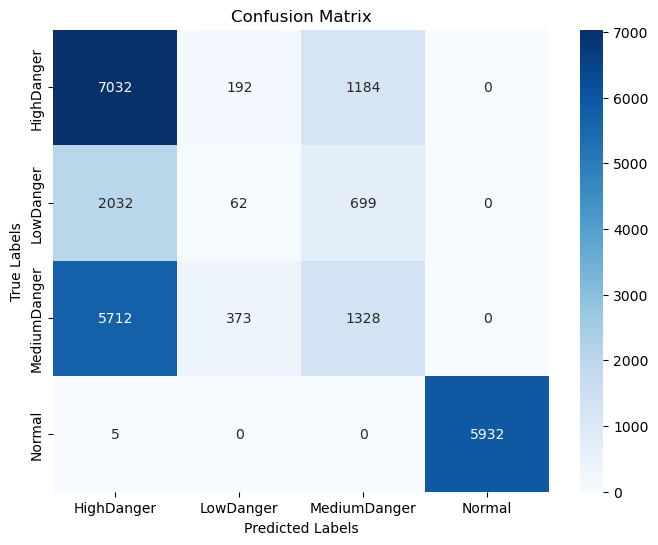

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [7]:
import numpy as np
import pandas as pd
print("Classification Report:")
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_labels, output_dict=True)
classification_df = pd.DataFrame(classification_rep).transpose()
print(classification_df)

Classification Report:
              precision    recall  f1-score       support
HighDanger     0.475746  0.836346  0.606494   8408.000000
LowDanger      0.098884  0.022198  0.036257   2793.000000
MediumDanger   0.413578  0.179145  0.250000   7413.000000
Normal         1.000000  0.999158  0.999579   5937.000000
accuracy       0.584661  0.584661  0.584661      0.584661
macro avg      0.497052  0.509212  0.473083  24551.000000
weighted avg   0.540879  0.584661  0.529038  24551.000000


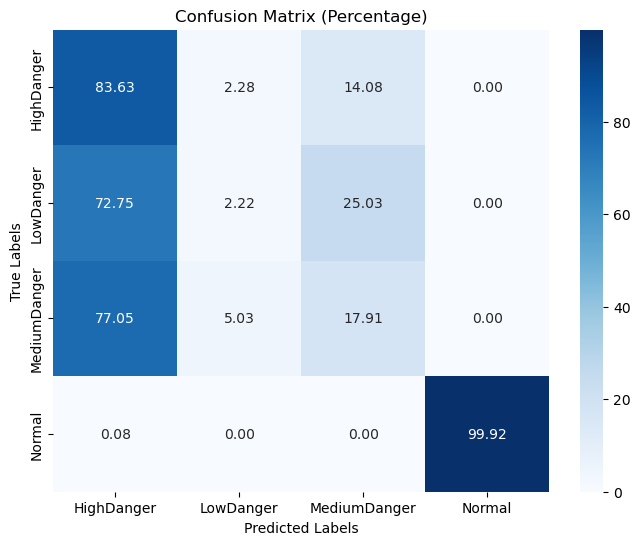

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate percentages from the confusion matrix
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix (Percentage)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


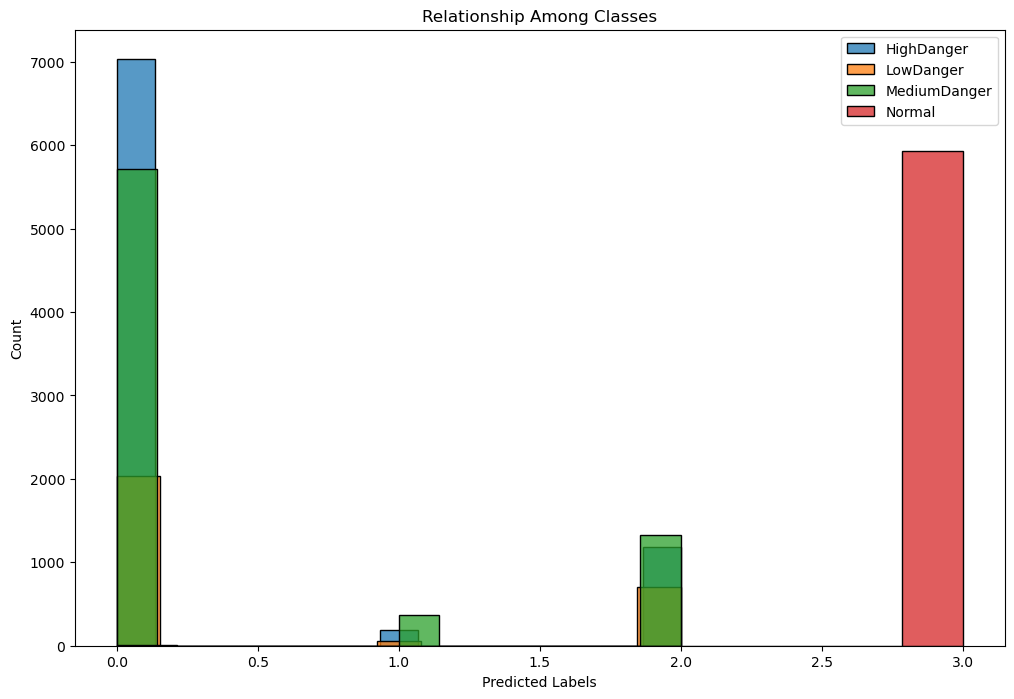

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

results_df = pd.DataFrame({'True Labels': true_labels, 'Predicted Labels': predicted_labels})

# Create a bar plot for each class
plt.figure(figsize=(12, 8))

for class_label in class_labels:
    subset_df = results_df[results_df['True Labels'] == class_labels.index(class_label)]
    sns.histplot(subset_df['Predicted Labels'], label=class_label, stat="count", common_norm=False, kde=False)

# Set plot title and labels
plt.title("Relationship Among Classes")
plt.xlabel("Predicted Labels")
plt.ylabel("Count")

# Show legend
plt.legend()

# Show the plot
plt.show()

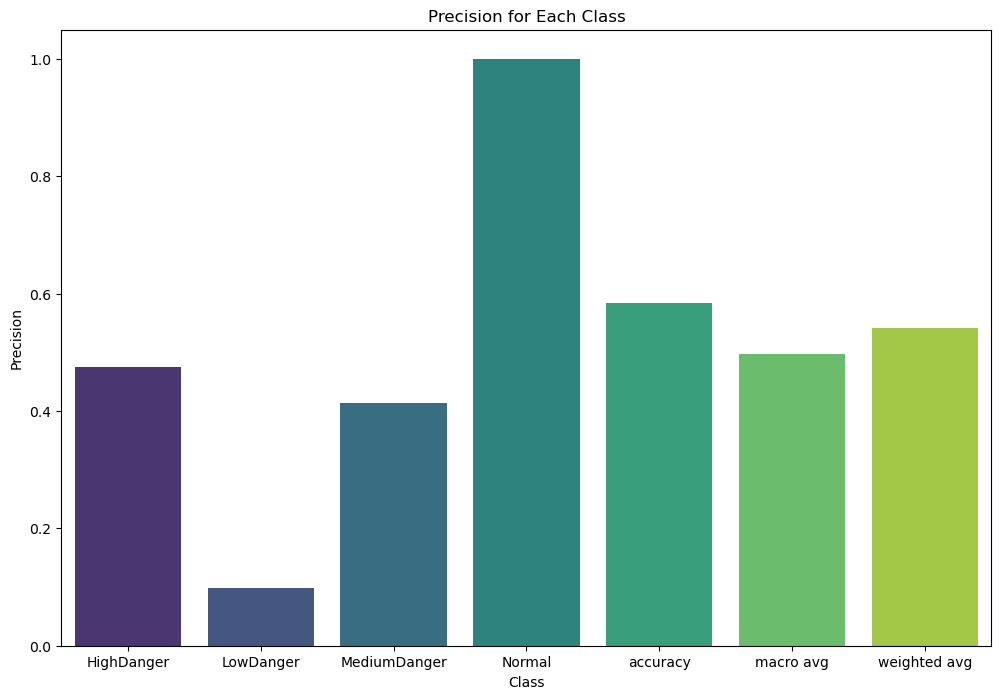

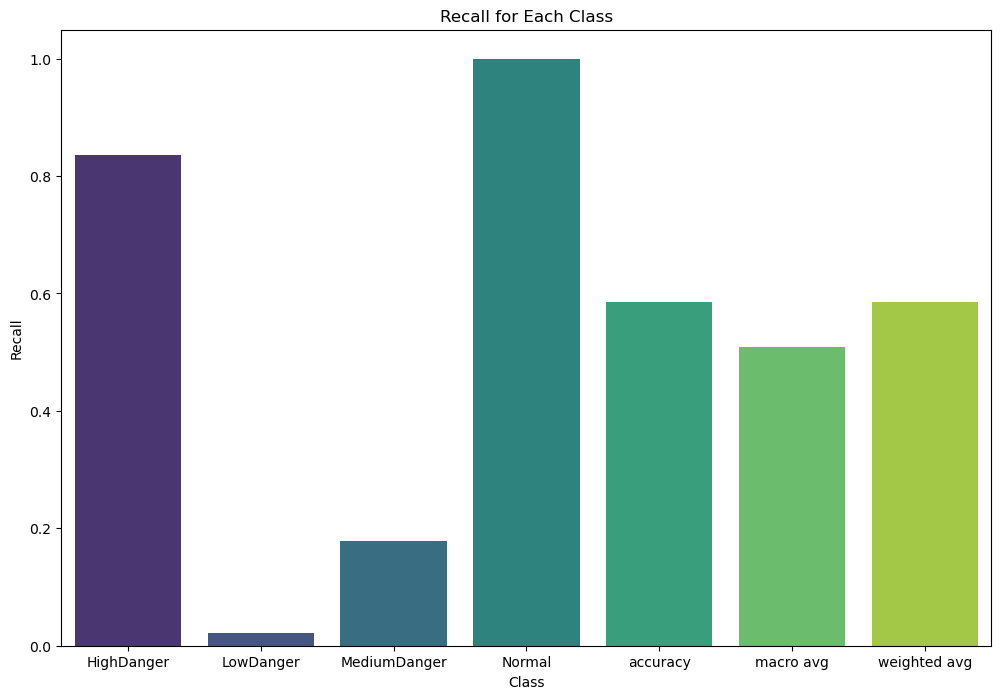

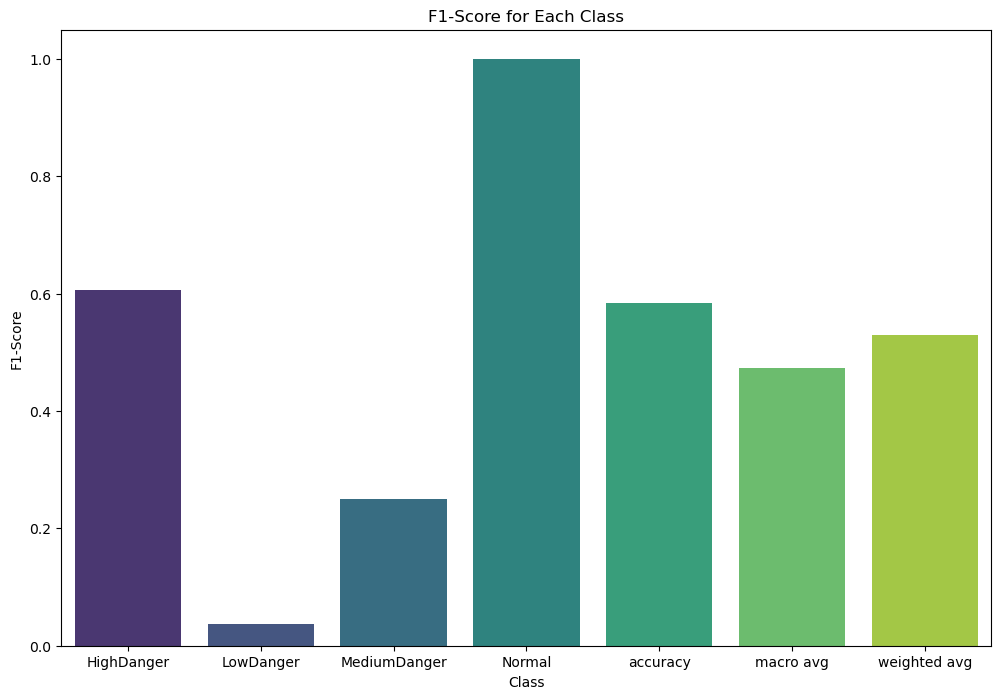

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming you have the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels, output_dict=True)

# Convert the classification report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot precision, recall, and f1-score for each class
plt.figure(figsize=(12, 8))

# Bar plot for precision
sns.barplot(x=report_df.index, y=report_df['precision'], palette='viridis')
plt.title('Precision for Each Class')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.show()

# Bar plot for recall
plt.figure(figsize=(12, 8))
sns.barplot(x=report_df.index, y=report_df['recall'], palette='viridis')
plt.title('Recall for Each Class')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.show()

# Bar plot for f1-score
plt.figure(figsize=(12, 8))
sns.barplot(x=report_df.index, y=report_df['f1-score'], palette='viridis')
plt.title('F1-Score for Each Class')
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.show()


# TEST 1

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import SGD
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import cv2
from skimage import feature, transform

class_labels = [
    'HighDanger', 'LowDanger', 'MediumDanger', 'Normal'
]

train1_data = r'D:\LEVEL_AHAR\Train'
validation1_data = r'D:\LEVEL_AHAR\Test'
IMG_SIZE = 160
LR = 1e-3
num_classes = len(class_labels)

x5 = class_labels.copy()
print(class_labels)

input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Block 1
layer0 = Conv2D(32, (7, 7), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv1')(input)
layer0 = BatchNormalization(name='bn1')(layer0)
layer0 = Activation('relu', name='relu1')(layer0)
layer0 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp1')(layer0)

skip_connection_1 = layer0

# Block 2
layer1 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv2')(layer0)
layer1 = BatchNormalization(name='bn2')(layer1)
layer1 = Activation('relu', name='relu2')(layer1)

layer2 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv3')(layer1)
layer2 = BatchNormalization(name='bn3')(layer2)
layer2 = Activation('relu', name='relu3')(layer2)

layer3 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv4')(layer2)
layer3 = BatchNormalization(name='bn4')(layer3)
layer3 = Activation('relu', name='relu4')(layer3)

layer4 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv5')(layer3)
layer4 = BatchNormalization(name='bn5')(layer4)
layer4 = Activation('relu', name='relu5')(layer4)

layer5 = keras.layers.concatenate([skip_connection_1, layer4])
layer5 = Conv2D(48, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv6')(layer5)
layer5 = BatchNormalization(name='bn6')(layer5)
layer5 = Activation('relu', name='relu6')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp2')(layer5)

skip_connection_2 = layer5

# Block 3
layer6 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv7')(layer5)
layer6 = BatchNormalization(name='bn7')(layer6)
layer6 = Activation('relu', name='relu7')(layer6)

layer7 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv8')(layer6)
layer7 = BatchNormalization(name='bn8')(layer7)
layer7 = Activation('relu', name='relu8')(layer7)

layer8 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv9')(layer7)
layer8 = BatchNormalization(name='bn9')(layer8)
layer8 = Activation('relu', name='relu9')(layer8)

layer9 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv10')(layer8)
layer9 = BatchNormalization(name='bn10')(layer9)
layer9 = Activation('relu', name='relu10')(layer9)

layer10 = keras.layers.concatenate([skip_connection_2, layer9])
layer10 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv11')(layer10)
layer10 = BatchNormalization(name='bn11')(layer10)
layer10 = Activation('relu', name='relu11')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp3')(layer10)

skip_connection_3 = layer10

# Output block
layer21 = Conv2D(num_classes, (1, 1), kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv22')(layer10)
layer21 = GlobalAveragePooling2D(name='gap1')(layer21)

output = Activation('softmax', name='softmax1')(layer21)

epochs1 = 25
lrate = 0.01
decay = lrate / epochs1
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model = Model(inputs=[input], outputs=[output])
model.summary()


# Image data generator with preprocessing steps
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    featurewise_center=False,
    featurewise_std_normalization=False,
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory(
    train1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=16,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    shuffle=True,
    subset='training',  # Specify that this is the training subset
    interpolation='bilinear',
    seed=42
)

test_set = test_datagen.flow_from_directory(
    validation1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    interpolation='bilinear',
    seed=42
)



# # Calculate class weights
# class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(training_set.classes), y=training_set.classes)
# class_weight_dict = dict(enumerate(class_weights))
# print("Class Weights:", class_weight_dict)

# Model compilation with class weights
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




# Train the model with class weights
model.fit(
    training_set,
    epochs=20,
    steps_per_epoch=len(training_set),
    validation_data=test_set,
    validation_steps=len(test_set),
#     class_weight=class_weight_dict  # Pass the calculated class weights
)

# Evaluate the model on the test set
eval_result = model.evaluate(test_set, steps=len(test_set))

# Extract predictions and true labels
predictions = model.predict(test_set, steps=len(test_set))
true_labels = test_set.classes

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


model.save('AHAR_equalvideos_savedmodel_epoch20_accuracy.h5')

['HighDanger', 'LowDanger', 'MediumDanger', 'Normal']
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 sep_conv1 (Conv2D)             (None, 160, 160, 32  1568        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormalization)       (None, 160, 160, 32  128         ['sep_conv1[0][0]']              
                                )     

 relu11 (Activation)            (None, 40, 40, 64)   0           ['bn11[0][0]']                   
                                                                                                  
 mp3 (MaxPooling2D)             (None, 20, 20, 64)   0           ['relu11[0][0]']                 
                                                                                                  
 sep_conv22 (Conv2D)            (None, 20, 20, 4)    256         ['mp3[0][0]']                    
                                                                                                  
 gap1 (GlobalAveragePooling2D)  (None, 4)            0           ['sep_conv22[0][0]']             
                                                                                                  
 softmax1 (Activation)          (None, 4)            0           ['gap1[0][0]']                   
                                                                                                  
Total para

In [5]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load your trained model
model_path = 'AHAR_equalvideos_savedmodel_epoch20_accuracy.h5'
model = load_model(model_path)

# Define class mapping based on danger levels
class_mapping = {
    'HighDanger':3,
    'LowDanger': 1,
    'MediumDanger': 2,
    'Normal': 0
}

# Open a video capture object
cap = cv2.VideoCapture(r'C:\Users\Harshi\Downloads\production_id_4052825 (2160p).mp4')

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame is valid
    if not ret:
        print("Error reading frame")
        break

    # Make a copy of the frame for display
    display_frame = frame.copy()

    # Preprocess the frame (resize, convert to grayscale, etc.)
    frame = cv2.resize(frame, (160, 160))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = img_to_array(frame)
    frame = preprocess_input(frame)
    frame = np.expand_dims(frame, axis=0)

    # Make predictions
    predictions = model.predict(frame)
    print(predictions)

#     # Convert predictions to class labels using class_mapping
#     predicted_label_index = np.argmax(predictions)
    
#     # Check if the predicted label index is in class_mapping
#     if predicted_label_index in class_mapping:
#         predicted_label = class_mapping[predicted_label_index]
#     else:
# #         print(f"Unexpected predicted label index: {predicted_label_index}")
#         predicted_label = 0

    predicted_label_index=np.argmax(predictions)
    print(predicted_label_index)
    
    keys_list=list(class_mapping.keys())
    
    key_at_index = keys_list[predicted_label_index]
    value_at_index = class_mapping[key_at_index]

    # Display the prediction on the copy of the frame
    cv2.putText(display_frame, f'Danger Level: {value_at_index}', (20, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow('Video Prediction', display_frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 154ms/step
[[9.9999988e-01 0.0000000e+00 1.3591871e-07 1.4838647e-14]]
0
1/1 [==============================] - 0s 16ms/step
[[9.9999988e-01 0.0000000e+00 1.3352492e-07 2.0071250e-14]]
0
1/1 [==============================] - 0s 16ms/step
[[9.9999988e-01 0.0000000e+00 1.5174227e-07 1.9472991e-14]]
0
1/1 [==============================] - 0s 17ms/step
[[9.9999988e-01 0.0000000e+00 1.4936865e-07 1.8962743e-14]]
0
1/1 [==============================] - 0s 11ms/step
[[9.9999988e-01 0.0000000e+00 1.3276966e-07 1.9360369e-14]]
0
1/1 [==============================] - 0s 10ms/step
[[9.9999988e-01 0.0000000e+00 1.3791148e-07 2.5265036e-14]]
0
1/1 [==============================] - 0s 16ms/step
[[9.9999988e-01 0.0000000e+00 1.5460914e-07 3.3579378e-14]]
0
1/1 [==============================] - 0s 16ms/step
[[9.9999988e-01 0.0000000e+00 1.5960615e-07 3.5031233e-14]]
0
1/1 [==============================] - 0s 16ms/step
[[9.9999988e-01 0.0000000e+00 1.694

# TEST 2

In [7]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import SGD
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import cv2
from skimage import feature, transform

class_labels = [
    'HighDanger', 'LowDanger', 'MediumDanger', 'Normal'
]

train1_data = r'D:\LEVEL_AHAR\Train'
validation1_data = r'D:\LEVEL_AHAR\Test'
IMG_SIZE = 160
LR = 1e-3
num_classes = len(class_labels)

x5 = class_labels.copy()
print(class_labels)

input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Block 1
layer0 = Conv2D(32, (7, 7), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv1')(input)
layer0 = BatchNormalization(name='bn1')(layer0)
layer0 = Activation('relu', name='relu1')(layer0)
layer0 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp1')(layer0)

skip_connection_1 = layer0

# Block 2
layer1 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv2')(layer0)
layer1 = BatchNormalization(name='bn2')(layer1)
layer1 = Activation('relu', name='relu2')(layer1)

layer2 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv3')(layer1)
layer2 = BatchNormalization(name='bn3')(layer2)
layer2 = Activation('relu', name='relu3')(layer2)

layer3 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv4')(layer2)
layer3 = BatchNormalization(name='bn4')(layer3)
layer3 = Activation('relu', name='relu4')(layer3)

layer4 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv5')(layer3)
layer4 = BatchNormalization(name='bn5')(layer4)
layer4 = Activation('relu', name='relu5')(layer4)

layer5 = keras.layers.concatenate([skip_connection_1, layer4])
layer5 = Conv2D(48, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv6')(layer5)
layer5 = BatchNormalization(name='bn6')(layer5)
layer5 = Activation('relu', name='relu6')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp2')(layer5)

skip_connection_2 = layer5

# Block 3
layer6 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv7')(layer5)
layer6 = BatchNormalization(name='bn7')(layer6)
layer6 = Activation('relu', name='relu7')(layer6)

layer7 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv8')(layer6)
layer7 = BatchNormalization(name='bn8')(layer7)
layer7 = Activation('relu', name='relu8')(layer7)

layer8 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv9')(layer7)
layer8 = BatchNormalization(name='bn9')(layer8)
layer8 = Activation('relu', name='relu9')(layer8)

layer9 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv10')(layer8)
layer9 = BatchNormalization(name='bn10')(layer9)
layer9 = Activation('relu', name='relu10')(layer9)

layer10 = keras.layers.concatenate([skip_connection_2, layer9])
layer10 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv11')(layer10)
layer10 = BatchNormalization(name='bn11')(layer10)
layer10 = Activation('relu', name='relu11')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp3')(layer10)

skip_connection_3 = layer10

# Output block
layer21 = Conv2D(num_classes, (1, 1), kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv22')(layer10)
layer21 = GlobalAveragePooling2D(name='gap1')(layer21)

output = Activation('softmax', name='softmax1')(layer21)

epochs1 = 25
lrate = 0.01
decay = lrate / epochs1
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model = Model(inputs=[input], outputs=[output])
model.summary()


# Image data generator with preprocessing steps
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    featurewise_center=False,
    featurewise_std_normalization=False,
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory(
    train1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=16,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    shuffle=True,
    subset='training',  # Specify that this is the training subset
    interpolation='bilinear',
    seed=42
)

test_set = test_datagen.flow_from_directory(
    validation1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    interpolation='bilinear',
    seed=42
)



# # Calculate class weights
# class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(training_set.classes), y=training_set.classes)
# class_weight_dict = dict(enumerate(class_weights))
# print("Class Weights:", class_weight_dict)

# Model compilation with class weights
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




# Train the model with class weights
model.fit(
    training_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_data=test_set,
    validation_steps=len(test_set),
#     class_weight=class_weight_dict  # Pass the calculated class weights
)

# Evaluate the model on the test set
eval_result = model.evaluate(test_set, steps=len(test_set))

# Extract predictions and true labels
predictions = model.predict(test_set, steps=len(test_set))
true_labels = test_set.classes

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


model.save('AHAR_lesshighvideos_savedmodel_epoch10_accuracy.h5')

['HighDanger', 'LowDanger', 'MediumDanger', 'Normal']
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 sep_conv1 (Conv2D)             (None, 160, 160, 32  1568        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormalization)       (None, 160, 160, 32  128         ['sep_conv1[0][0]']              
                                )     

 relu11 (Activation)            (None, 40, 40, 64)   0           ['bn11[0][0]']                   
                                                                                                  
 mp3 (MaxPooling2D)             (None, 20, 20, 64)   0           ['relu11[0][0]']                 
                                                                                                  
 sep_conv22 (Conv2D)            (None, 20, 20, 4)    256         ['mp3[0][0]']                    
                                                                                                  
 gap1 (GlobalAveragePooling2D)  (None, 4)            0           ['sep_conv22[0][0]']             
                                                                                                  
 softmax1 (Activation)          (None, 4)            0           ['gap1[0][0]']                   
                                                                                                  
Total para

In [10]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load your trained model
model_path = 'AHAR_lesshighvideos_savedmodel_epoch10_accuracy.h5'
model = load_model(model_path)

# Define class mapping based on danger levels
class_mapping = {
    'HighDanger':3,
    'LowDanger': 1,
    'MediumDanger': 2,
    'Normal': 0
}

# Open a video capture object
cap = cv2.VideoCapture(r'C:\Users\Harshi\Downloads\production_id_4052825 (2160p).mp4')

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame is valid
    if not ret:
        print("Error reading frame")
        break

    # Make a copy of the frame for display
    display_frame = frame.copy()

    # Preprocess the frame (resize, convert to grayscale, etc.)
    frame = cv2.resize(frame, (160, 160))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = img_to_array(frame)
    frame = preprocess_input(frame)
    frame = np.expand_dims(frame, axis=0)

    # Make predictions
    predictions = model.predict(frame)
    print(predictions)

#     # Convert predictions to class labels using class_mapping
#     predicted_label_index = np.argmax(predictions)
    
#     # Check if the predicted label index is in class_mapping
#     if predicted_label_index in class_mapping:
#         predicted_label = class_mapping[predicted_label_index]
#     else:
# #         print(f"Unexpected predicted label index: {predicted_label_index}")
#         predicted_label = 0

    predicted_label_index=np.argmax(predictions)
    print(predicted_label_index)
    
    keys_list=list(class_mapping.keys())
    
    key_at_index = keys_list[predicted_label_index]
    value_at_index = class_mapping[key_at_index]

    # Display the prediction on the copy of the frame
    cv2.putText(display_frame, f'Danger Level: {value_at_index}', (20, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow('Video Prediction', display_frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 145ms/step
[[1.7068535e-02 2.8364567e-02 1.8642393e-04 9.5438045e-01]]
3
1/1 [==============================] - 0s 10ms/step
[[2.0842317e-02 3.2004502e-02 2.2088885e-04 9.4693232e-01]]
3
1/1 [==============================] - 0s 15ms/step
[[1.9903600e-02 2.8871441e-02 2.3366143e-04 9.5099133e-01]]
3
1/1 [==============================] - 0s 19ms/step
[[2.0735212e-02 3.0619670e-02 2.6221847e-04 9.4838291e-01]]
3
1/1 [==============================] - 0s 10ms/step
[[2.0597421e-02 3.5137262e-02 2.7300944e-04 9.4399226e-01]]
3
1/1 [==============================] - 0s 10ms/step
[[2.2707254e-02 4.5613043e-02 3.0853850e-04 9.3137121e-01]]
3
1/1 [==============================] - 0s 10ms/step
[[2.0294096e-02 4.4110857e-02 2.8600535e-04 9.3530905e-01]]
3
1/1 [==============================] - 0s 20ms/step
[[2.7335843e-02 5.8119167e-02 4.0854586e-04 9.1413647e-01]]
3
1/1 [==============================] - 0s 14ms/step
[[2.5210032e-02 5.2671529e-02 3.889

1/1 [==============================] - 0s 15ms/step
[[0.11450103 0.282843   0.00234611 0.6003099 ]]
3
1/1 [==============================] - 0s 11ms/step
[[0.09863527 0.2667932  0.00216295 0.6324085 ]]
3
1/1 [==============================] - 0s 20ms/step
[[0.09527094 0.23552622 0.00219831 0.6670045 ]]
3
1/1 [==============================] - 0s 6ms/step
[[0.11929695 0.23953937 0.00276057 0.6384031 ]]
3
1/1 [==============================] - 0s 14ms/step
[[0.14853264 0.2563505  0.00354768 0.5915692 ]]
3
1/1 [==============================] - 0s 9ms/step
[[0.17385826 0.32011577 0.00375275 0.5022732 ]]
3
1/1 [==============================] - 0s 10ms/step
[[0.18791538 0.35798243 0.00372653 0.45037562]]
3
1/1 [==============================] - 0s 12ms/step
[[0.1821145  0.40055877 0.00335817 0.4139686 ]]
3
1/1 [==============================] - 0s 12ms/step
[[0.16223598 0.45820865 0.00272451 0.37683088]]
1
1/1 [==============================] - 0s 10ms/step
[[0.14321117 0.4585424  0.002326

1/1 [==============================] - 0s 16ms/step
[[0.17973465 0.3344883  0.00118458 0.48459238]]
3
1/1 [==============================] - 0s 18ms/step
[[0.18124077 0.34040222 0.00116607 0.4771909 ]]
3
1/1 [==============================] - 0s 18ms/step
[[0.18824027 0.36942682 0.00122752 0.4411054 ]]
3
1/1 [==============================] - 0s 16ms/step
[[0.19160822 0.3629453  0.00133332 0.44411322]]
3
1/1 [==============================] - 0s 16ms/step
[[0.20371638 0.38307205 0.00143485 0.41177675]]
3
1/1 [==============================] - 0s 16ms/step
[[0.20398983 0.39053047 0.00141305 0.40406662]]
3
1/1 [==============================] - 0s 13ms/step
[[0.21111864 0.4082712  0.00143021 0.37917992]]
1
1/1 [==============================] - 0s 16ms/step
[[0.21312489 0.40281284 0.00151164 0.3825506 ]]
1
1/1 [==============================] - 0s 16ms/step
[[0.21999818 0.41611612 0.00164984 0.36223584]]
1
1/1 [==============================] - 0s 12ms/step
[[0.22011715 0.42208618 0.0016

# TEST 3

In [12]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
# from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import img_to_array, load_img,array_to_img
import cv2
from skimage import feature, transform


class_labels = [
    'Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting',
    'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism'
]

train1_data = r'D:\OUTPUT_AHAR\Train'
validation1_data = r'D:\OUTPUT_AHAR\Test'
IMG_SIZE = 160
LR = 1e-3
num_classes = len(class_labels)


x5 = class_labels.copy()
print(class_labels)

input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Block 1
layer0 = Conv2D(32, (7, 7), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv1')(input)
layer0 = BatchNormalization(name='bn1')(layer0)
layer0 = Activation('relu', name='relu1')(layer0)
layer0 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp1')(layer0)

skip_connection_1 = layer0

# Block 2
layer1 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv2')(layer0)
layer1 = BatchNormalization(name='bn2')(layer1)
layer1 = Activation('relu', name='relu2')(layer1)

layer2 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv3')(layer1)
layer2 = BatchNormalization(name='bn3')(layer2)
layer2 = Activation('relu', name='relu3')(layer2)

layer3 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv4')(layer2)
layer3 = BatchNormalization(name='bn4')(layer3)
layer3 = Activation('relu', name='relu4')(layer3)

layer4 = Conv2D(48, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv5')(layer3)
layer4 = BatchNormalization(name='bn5')(layer4)
layer4 = Activation('relu', name='relu5')(layer4)

layer5 = keras.layers.concatenate([skip_connection_1, layer4])
layer5 = Conv2D(48, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv6')(layer5)
layer5 = BatchNormalization(name='bn6')(layer5)
layer5 = Activation('relu', name='relu6')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp2')(layer5)

skip_connection_2 = layer5

# Block 3
layer6 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv7')(layer5)
layer6 = BatchNormalization(name='bn7')(layer6)
layer6 = Activation('relu', name='relu7')(layer6)

layer7 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv8')(layer6)
layer7 = BatchNormalization(name='bn8')(layer7)
layer7 = Activation('relu', name='relu8')(layer7)

layer8 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv9')(layer7)
layer8 = BatchNormalization(name='bn9')(layer8)
layer8 = Activation('relu', name='relu9')(layer8)

layer9 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv10')(layer8)
layer9 = BatchNormalization(name='bn10')(layer9)
layer9 = Activation('relu', name='relu10')(layer9)

layer10 = keras.layers.concatenate([skip_connection_2, layer9])
layer10 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv11')(layer10)
layer10 = BatchNormalization(name='bn11')(layer10)
layer10 = Activation('relu', name='relu11')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='mp3')(layer10)

skip_connection_3 = layer10

# Output block
layer21 = Conv2D(num_classes, (1, 1), kernel_regularizer=keras.regularizers.l2(1e-4), use_bias=False, kernel_initializer='he_normal', name='sep_conv22')(layer10)
layer21 = GlobalAveragePooling2D(name='gap1')(layer21)

output = Activation('softmax', name='softmax1')(layer21)

epochs1 = 25
lrate = 0.01
decay = lrate / epochs1
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model = Model(inputs=[input], outputs=[output])
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# Image data generator with preprocessing steps
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    featurewise_center=False,
    featurewise_std_normalization=False,
    
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory(
    train1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=16,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    shuffle=True,
    subset='training',  # Specify that this is the training subset
    interpolation='bilinear',
    seed=42
)

test_set = test_datagen.flow_from_directory(
    validation1_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=x5,
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',  # Set color_mode to 'grayscale' for single-channel images
    interpolation='bilinear',
    seed=42
)

model.fit(
    training_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_data=test_set,
    validation_steps=len(test_set)
)


# Evaluate the model on the test set
eval_result = model.evaluate(test_set, steps=len(test_set))

# Extract predictions and true labels
predictions = model.predict(test_set, steps=len(test_set))
true_labels = test_set.classes

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

model.save('AHAR_new13videos_savedmodel_epoch10_accuracy.h5')

['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 sep_conv1 (Conv2D)             (None, 160, 160, 32  1568        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormali

 bn11 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv11[0][0]']             
                                                                                                  
 relu11 (Activation)            (None, 40, 40, 64)   0           ['bn11[0][0]']                   
                                                                                                  
 mp3 (MaxPooling2D)             (None, 20, 20, 64)   0           ['relu11[0][0]']                 
                                                                                                  
 sep_conv22 (Conv2D)            (None, 20, 20, 14)   896         ['mp3[0][0]']                    
                                                                                                  
 gap1 (GlobalAveragePooling2D)  (None, 14)           0           ['sep_conv22[0][0]']             
                                                                                                  
 softmax1 

 relu9 (Activation)             (None, 40, 40, 64)   0           ['bn9[0][0]']                    
                                                                                                  
 sep_conv10 (Conv2D)            (None, 40, 40, 64)   36864       ['relu9[0][0]']                  
                                                                                                  
 bn10 (BatchNormalization)      (None, 40, 40, 64)   256         ['sep_conv10[0][0]']             
                                                                                                  
 relu10 (Activation)            (None, 40, 40, 64)   0           ['bn10[0][0]']                   
                                                                                                  
 concatenate_11 (Concatenate)   (None, 40, 40, 112)  0           ['mp2[0][0]',                    
                                                                  'relu10[0][0]']                 
          

In [15]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load your trained model
model_path = 'AHAR_new13videos_savedmodel_epoch10_accuracy.h5'
model = load_model(model_path)

# Define class mapping based on danger levels
class_mapping = {
    'Abuse': 2,          # Medium danger
    'Arrest': 1,         # High danger
    'Arson': 3,          # High danger
    'Assault': 2,        # Medium danger
    'Burglary': 3,       # High danger
    'Explosion': 3,      # High danger
    'Fighting': 2,       # Medium danger
    'NormalVideos': 0,   # Normal
    'RoadAccidents': 1,  # Low danger
    'Robbery': 3,        # High danger
    'Shooting': 3,       # High danger
    'Shoplifting': 1,    # Low danger
    'Stealing': 2,       # Medium danger
    'Vandalism': 2       # Medium danger
}

# Open a video capture object
cap = cv2.VideoCapture(r'C:\Users\Harshi\Downloads\mixkit-boxers-hitting-in-a-fight-40967-medium.mp4')

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame is valid
    if not ret:
        print("Error reading frame")
        break

    # Make a copy of the frame for display
    display_frame = frame.copy()

    # Preprocess the frame (resize, convert to grayscale, etc.)
    frame = cv2.resize(frame, (160, 160))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = img_to_array(frame)
    frame = preprocess_input(frame)
    frame = np.expand_dims(frame, axis=0)

    # Make predictions
    predictions = model.predict(frame)
    print(predictions)

#     # Convert predictions to class labels using class_mapping
#     predicted_label_index = np.argmax(predictions)
    
#     # Check if the predicted label index is in class_mapping
#     if predicted_label_index in class_mapping:
#         predicted_label = class_mapping[predicted_label_index]
#     else:
# #         print(f"Unexpected predicted label index: {predicted_label_index}")
#         predicted_label = 0

    predicted_label_index=np.argmax(predictions)
    print(predicted_label_index)
    
    keys_list=list(class_mapping.keys())
    
    key_at_index = keys_list[predicted_label_index]
    value_at_index = class_mapping[key_at_index]

    # Display the prediction on the copy of the frame
    cv2.putText(display_frame, f'Danger Level: {value_at_index}', (20, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow('Video Prediction', display_frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 141ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 1.7417386e-34
  0.0000000e+00 0.0000000e+00 0.0000000e+00 2.1383712e-22 0.0000000e+00
  0.0000000e+00 3.1662454e-29 0.0000000e+00 1.0190777e-30]]
1
1/1 [==============================] - 0s 16ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 1.3679827e-34
  0.0000000e+00 0.0000000e+00 0.0000000e+00 9.1403243e-23 0.0000000e+00
  0.0000000e+00 1.2594508e-28 0.0000000e+00 3.5880568e-30]]
1
1/1 [==============================] - 0s 23ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 7.0263694e-35
  0.0000000e+00 0.0000000e+00 0.0000000e+00 4.9004383e-23 0.0000000e+00
  0.0000000e+00 9.2711042e-29 0.0000000e+00 4.2639149e-30]]
1
1/1 [==============================] - 0s 16ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 9.4554464e-35
  0.0000000e+00 0.0000000e+00 0.0000000e+00 4.0414143e-23 0.0000000e+00
  0.0000000e+00 1.1858828e-28

1/1 [==============================] - 0s 10ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 4.9514118e-33
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3283521e-23 0.0000000e+00
  0.0000000e+00 1.1784400e-24 0.0000000e+00 1.0036292e-25]]
1
1/1 [==============================] - 0s 16ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 5.1963635e-33
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.5611322e-23 0.0000000e+00
  0.0000000e+00 9.2125652e-25 0.0000000e+00 5.8183404e-26]]
1
1/1 [==============================] - 0s 16ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 4.3343772e-33
  0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9998067e-24 0.0000000e+00
  0.0000000e+00 1.7753960e-24 0.0000000e+00 3.8803476e-26]]
1
1/1 [==============================] - 0s 2ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 8.3308614e-33
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.7256116e-23 0.0000000e+00
  0.0000000e+00 2.6782303e-24 0

1/1 [==============================] - 0s 769us/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 1.8038543e-34
  0.0000000e+00 0.0000000e+00 0.0000000e+00 3.8431990e-24 0.0000000e+00
  0.0000000e+00 8.5135092e-24 0.0000000e+00 2.9476016e-26]]
1
1/1 [==============================] - 0s 5ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 6.1935626e-35
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.9345544e-24 0.0000000e+00
  0.0000000e+00 2.8085929e-24 0.0000000e+00 1.0994527e-26]]
1
1/1 [==============================] - 0s 9ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 4.8081565e-35
  0.0000000e+00 0.0000000e+00 0.0000000e+00 2.1209188e-24 0.0000000e+00
  0.0000000e+00 1.9303673e-24 0.0000000e+00 4.7801770e-27]]
1
1/1 [==============================] - 0s 6ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 6.8518320e-35
  0.0000000e+00 0.0000000e+00 0.0000000e+00 2.8702761e-24 0.0000000e+00
  0.0000000e+00 2.8272430e-24 0.